In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt



training_set_size = 2000
validation_set_size = 200
interval = 2
bit_much = 1   # let's see what happens if we see a little bit outside our interval



In [84]:
class SinApproximator(nn.Module):
    
    def __init__(self, nodes=10):

        super(SinApproximator, self).__init__()
        
        self.fc = nn.Linear(2, nodes)  # Input: x, sin(x), rand()
        self.hidden = nn.ReLU()
        self.out = nn.Linear(nodes, 1)  # Output: approximated sin(x)

    def forward(self, x):
        x = self.hidden(self.fc(x))
        x = self.out(x)
        return x


In [ ]:
def generate_data(training_set_size, validation_set_size, how):

    if how=="linspace":
        x = np.linspace(-interval * np.pi, interval * np.pi, training_set_size)
    if how=="random":
        x = np.random.uniform(-interval*np.pi, interval*np.pi, training_set_size)
        
    sin_x = np.sin(x)
    noise = np.random.rand(training_set_size)  # Random noise
    training_set = np.vstack([x, noise]).T  # Combine x, and rand()

    validation_set_ = np.linspace(-interval * np.pi, interval * np.pi, validation_set_size)    
    y_validation = np.sin(validation_set_)
    validation_set = np.vstack([validation_set_, np.zeros_like(validation_set_)]).T


    
    return (torch.tensor(training_set, dtype=torch.float32), 
            torch.tensor(sin_x, dtype=torch.float32).unsqueeze(1), 
            torch.tensor(validation_set, dtype=torch.float32),
            torch.tensor(y_validation, dtype=torch.float32))



In [ ]:

# Training function
def train(model, X, y, validation_set, validaiton_set_y, num_epochs=10000, learning_rate=0.01, lambda_reg=1.0, order=2):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    weights_b = []
    losses = []
    losses_validation = []

    for epoch in range(num_epochs):
        
        optimizer.zero_grad()

        # Validation loss
        validation_predicted = model(torch.tensor(validation_set, dtype=torch.float32))
        loss_validation = criterion(validation_predicted, validaiton_set_y)
        losses_validation.append(loss_validation) 

        optimizer.zero_grad()
        outputs = model(X)

        # Training loss
        loss = criterion(outputs, y)

        # Regularization on weights associated with random input
        reg_loss = 0

        if order == 1:
            norm_weights = torch.sum(torch.abs(model.fc.weight[:, 1]))     # ok
        if order ==2:
            norm_weights = torch.sum(model.fc.weight[:, 1]**2)             # ok
       
        reg_loss = lambda_reg * norm_weights  

        total_loss = loss + reg_loss


        
        losses.append(total_loss.item())
        weights_b.append(np.sum(model.fc.weight.data[:,1].numpy()))

        total_loss.backward()
        optimizer.step()


    
    return weights_b, losses, losses_validation

/var/folders/cd/x29qw_lj0yzf26xq_q6rzr3r0000gn/T/ipykernel_22590/2519936882.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_predicted = model(torch.tensor(validation_set, dtype=torch.float32))


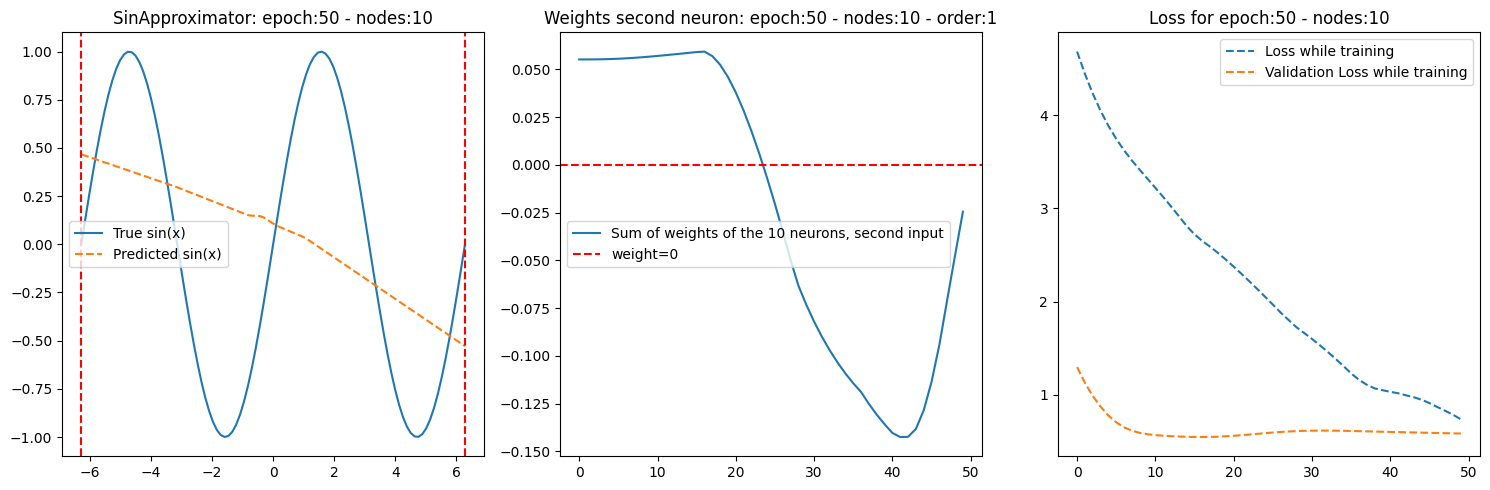

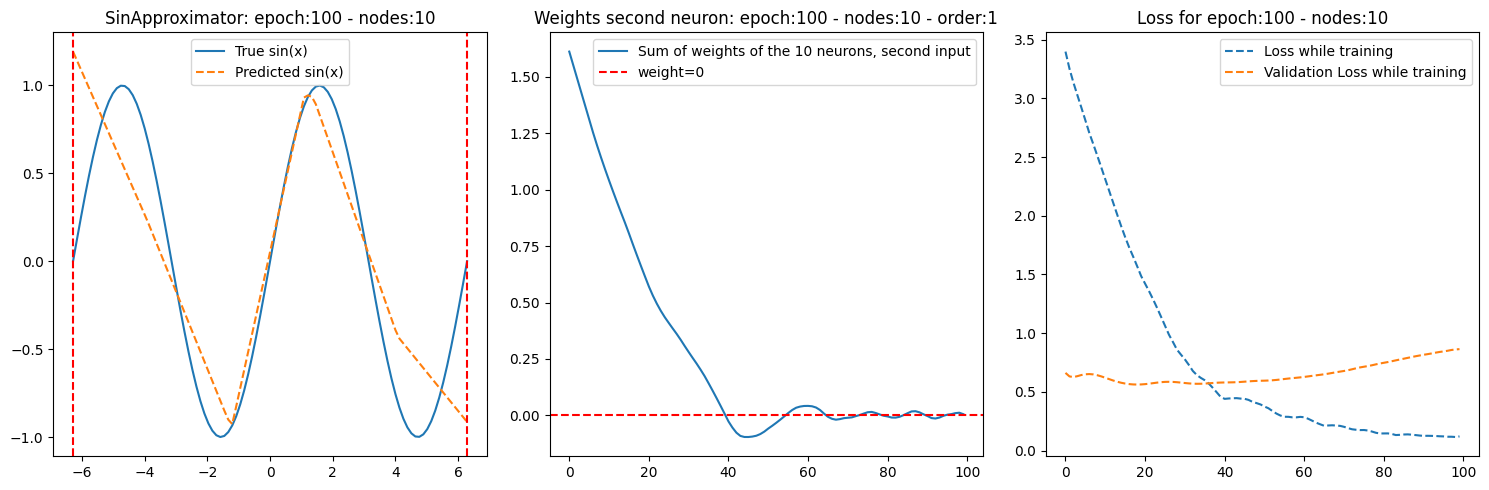

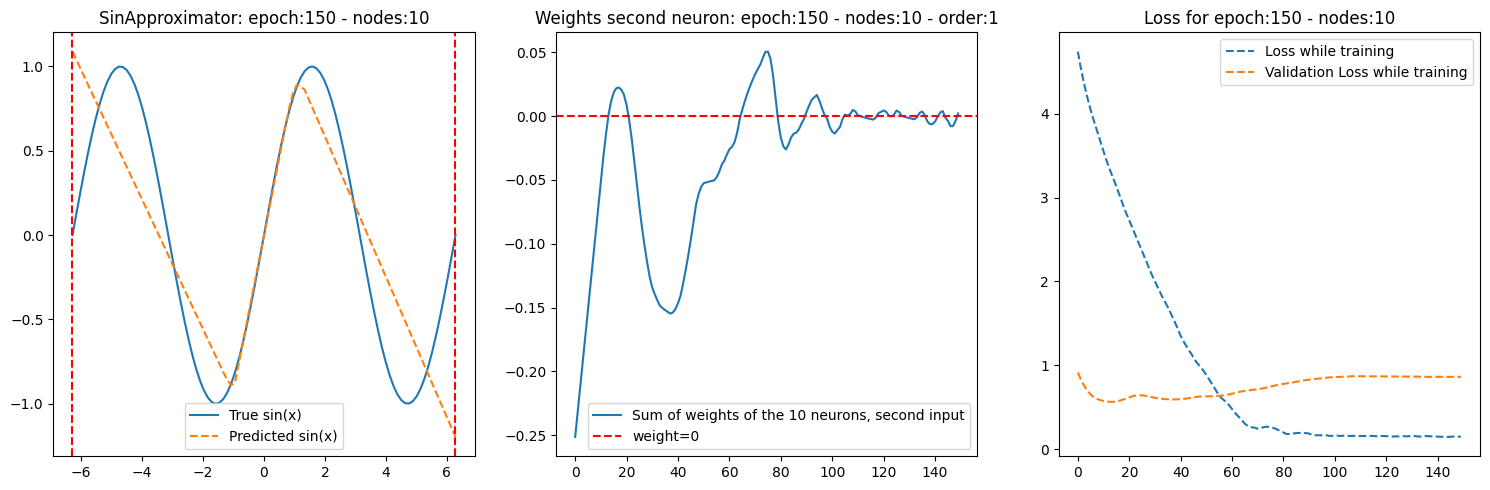

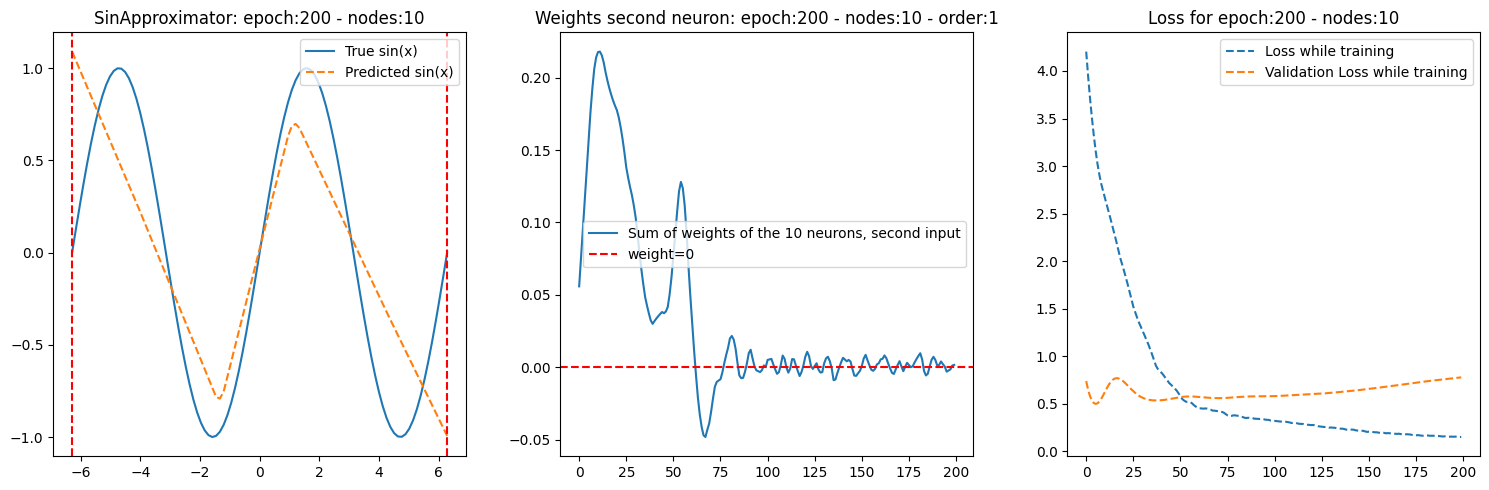

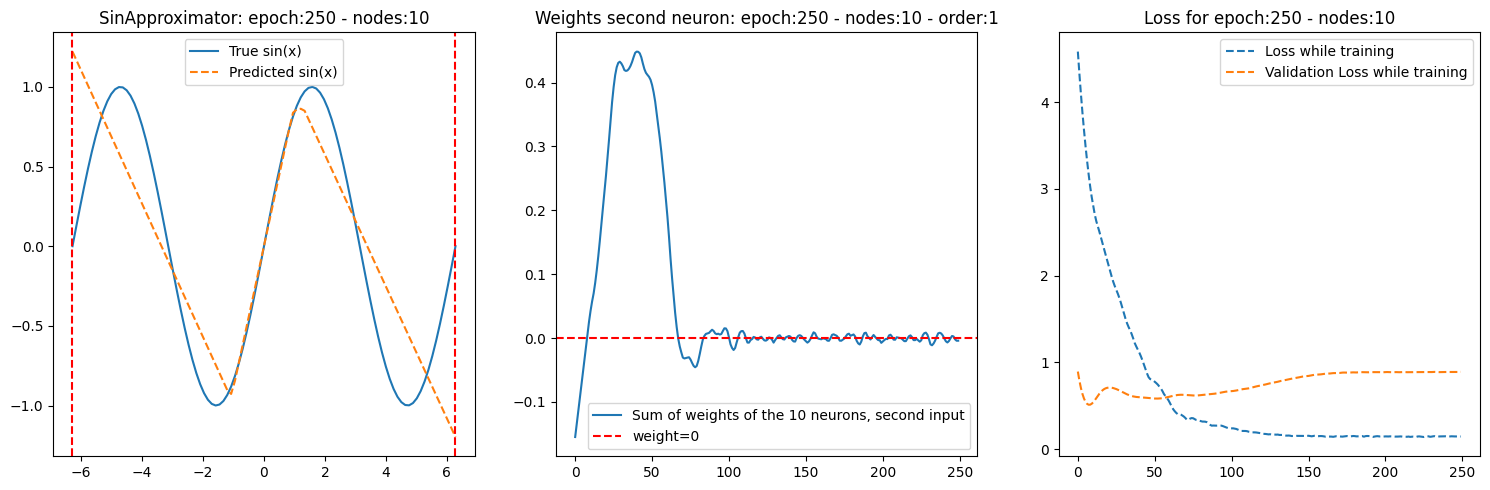

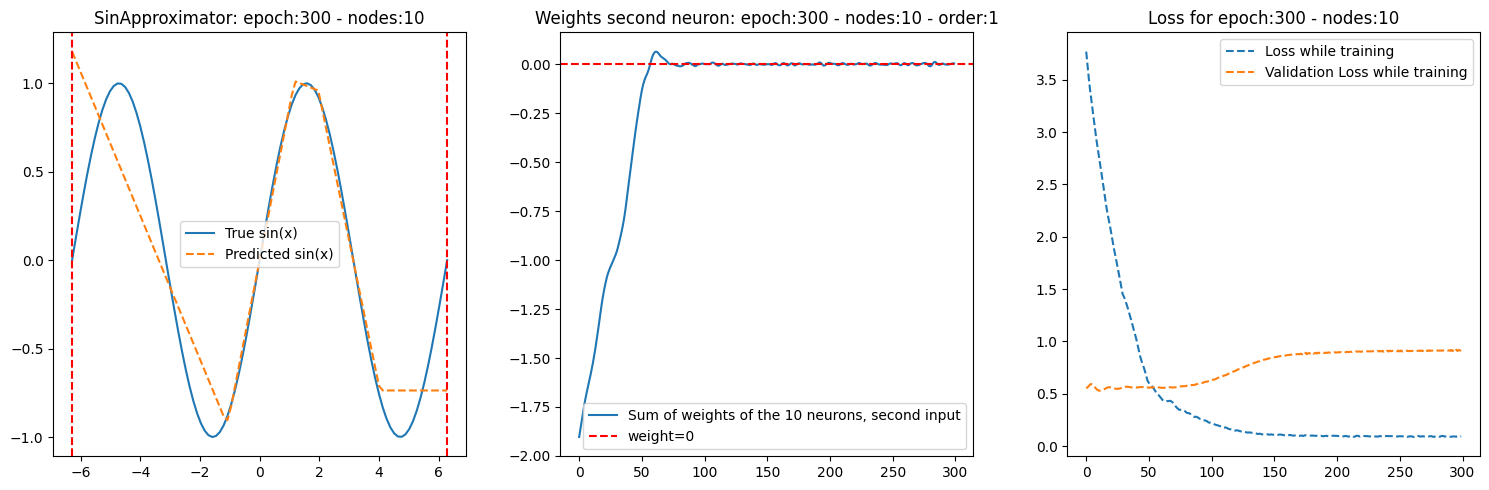

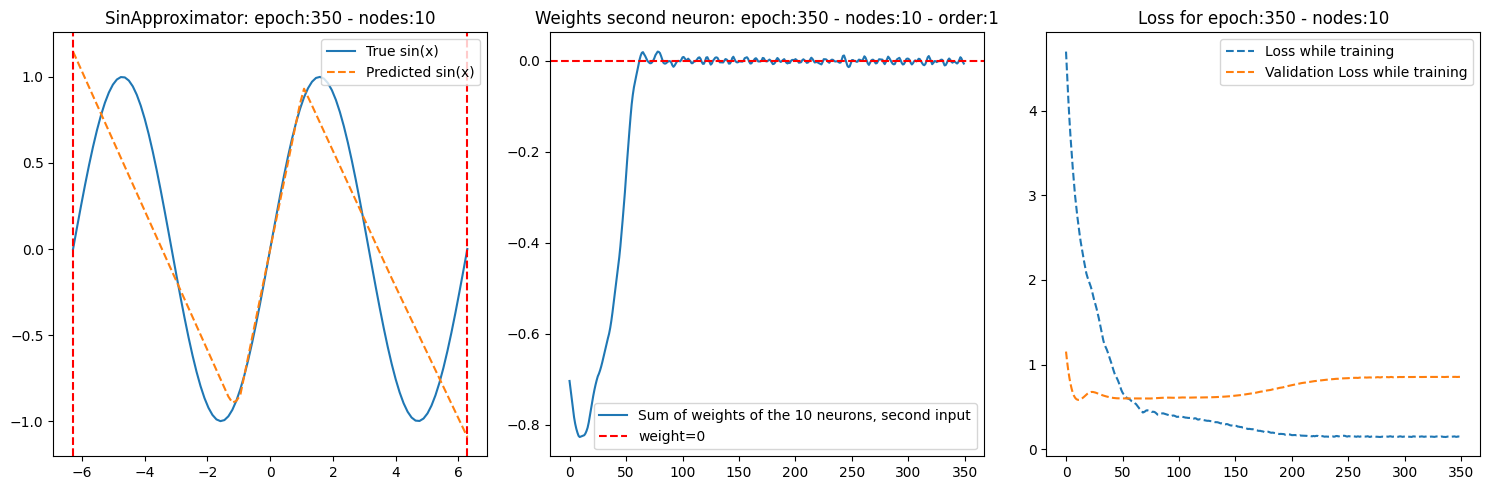

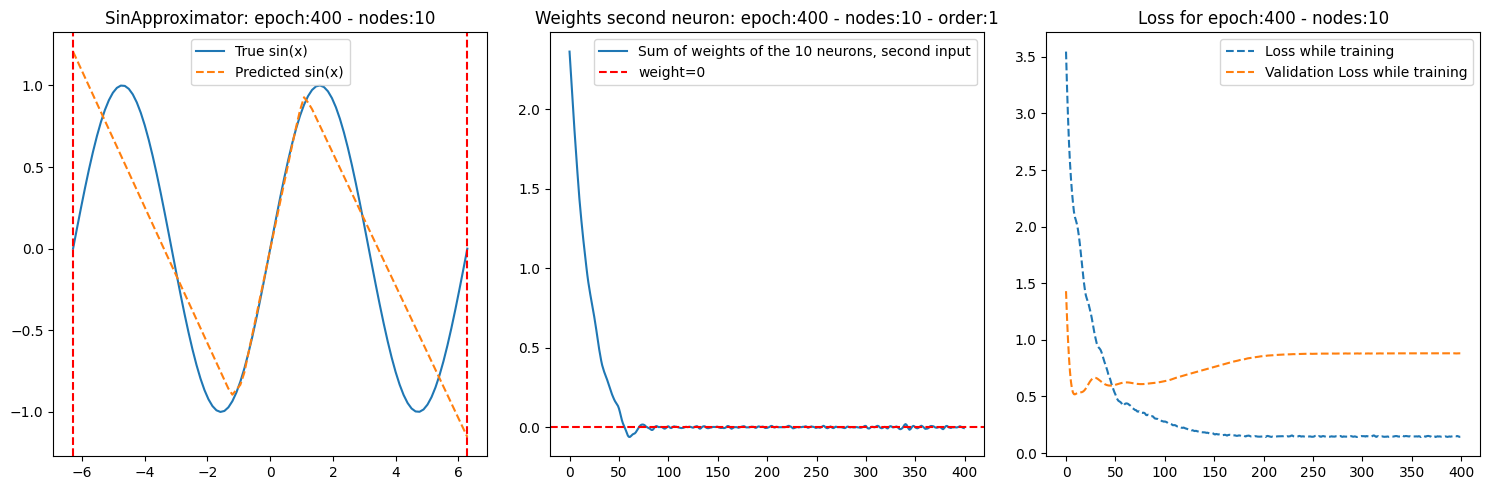

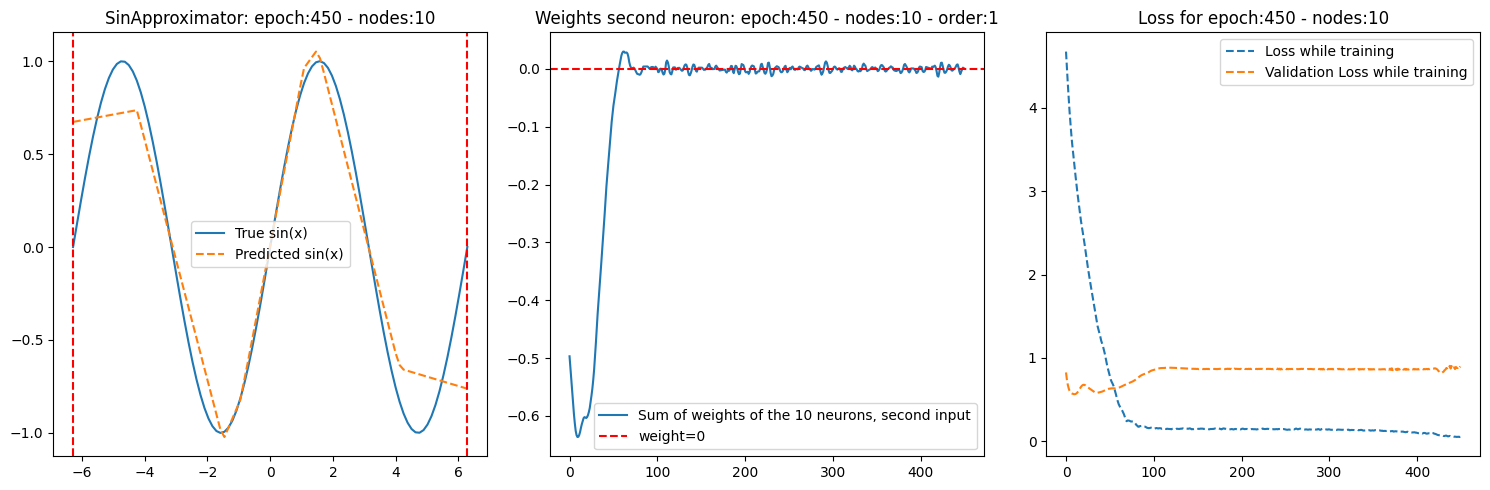

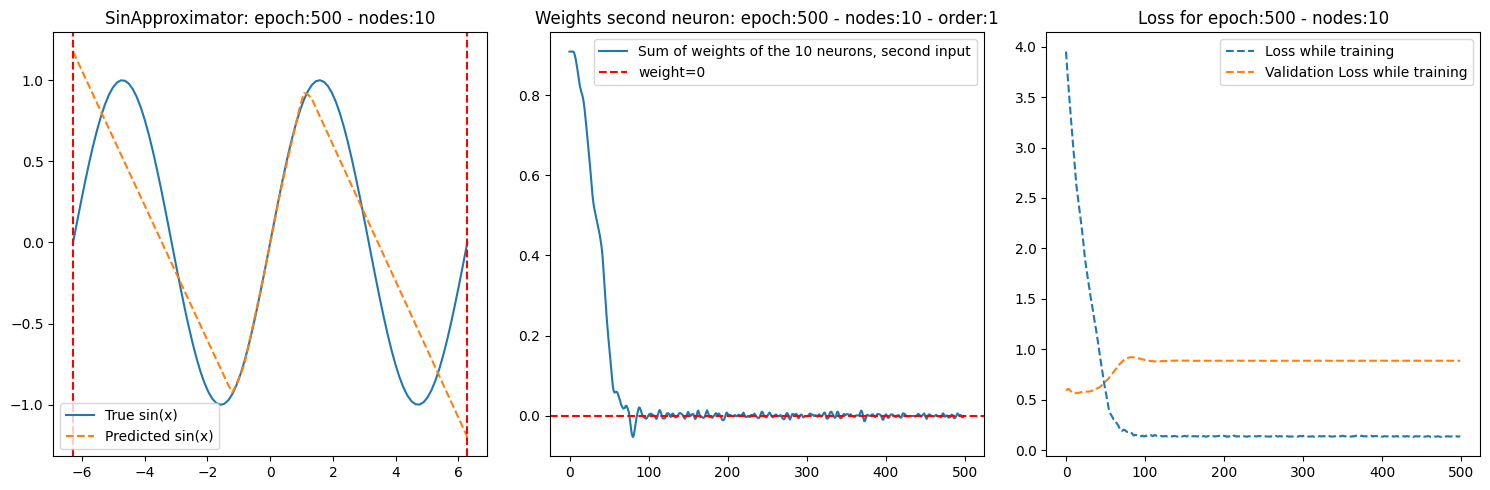

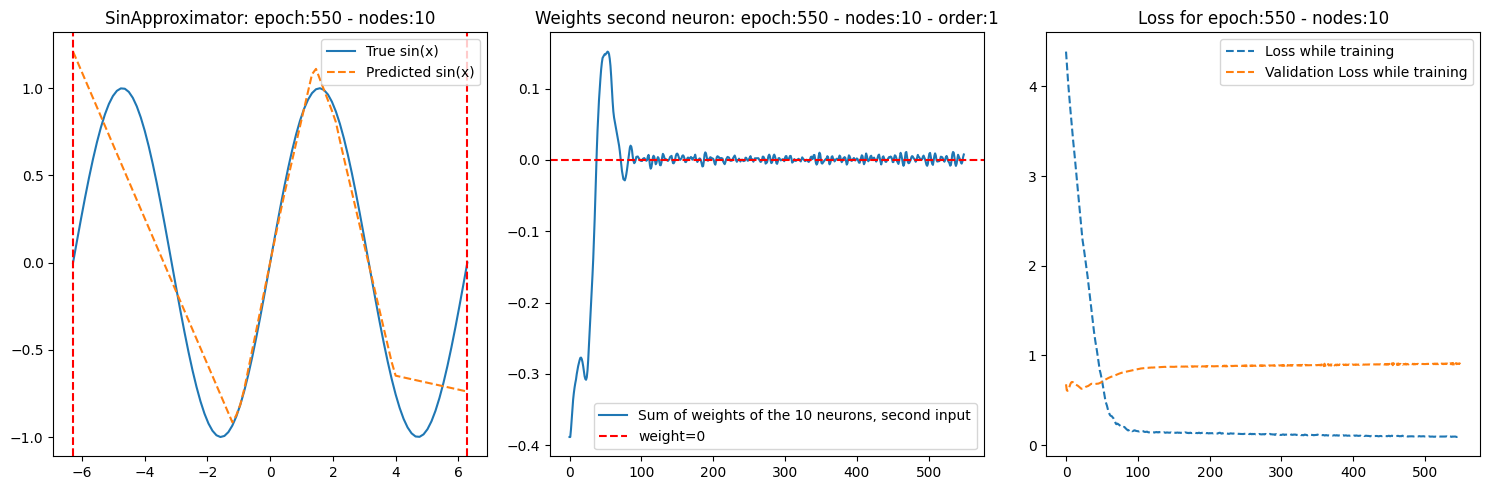

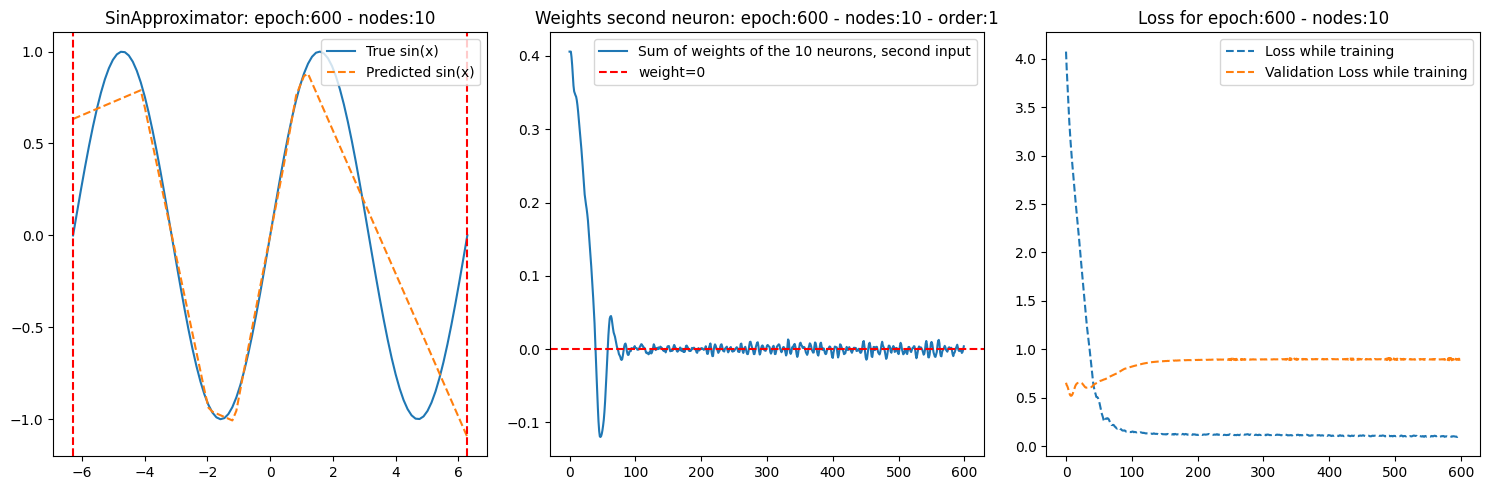

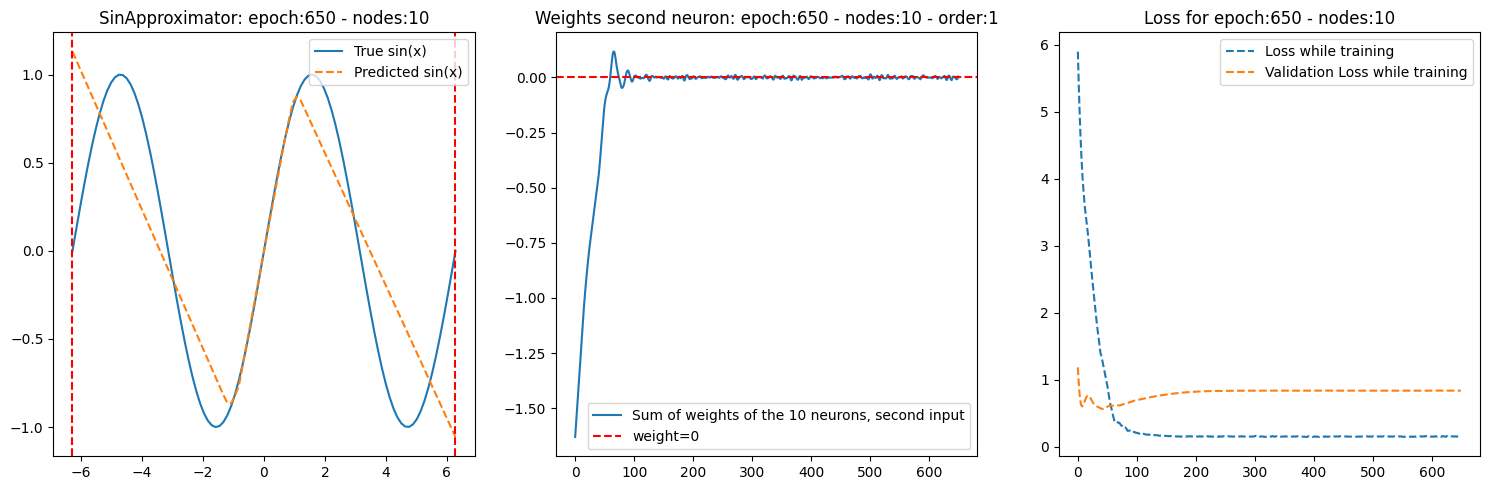

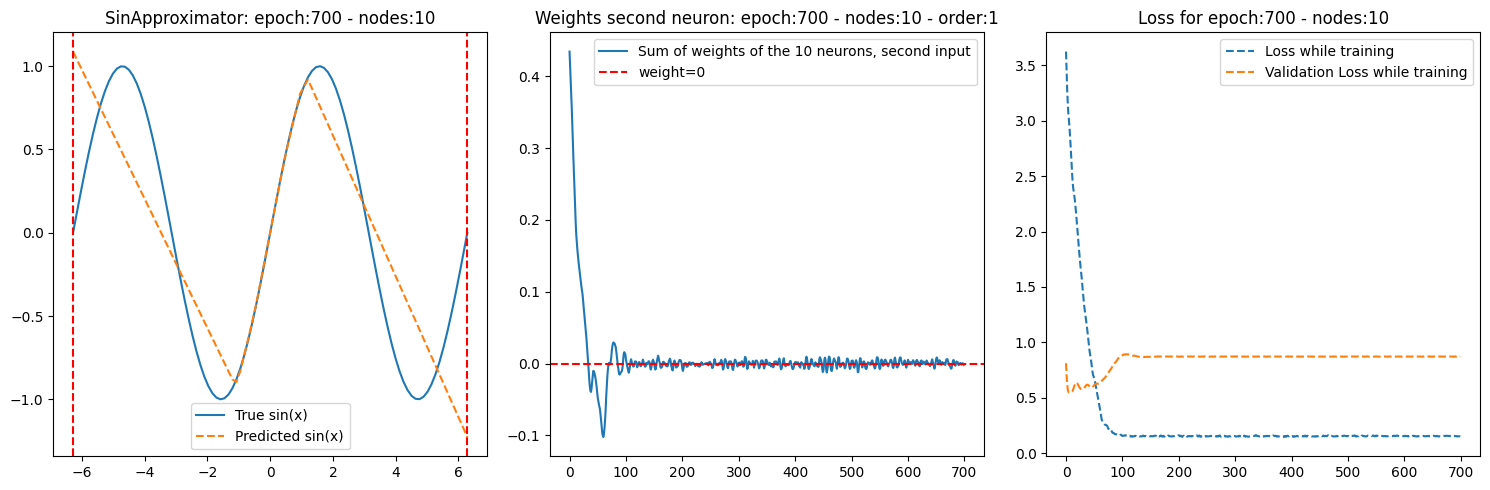

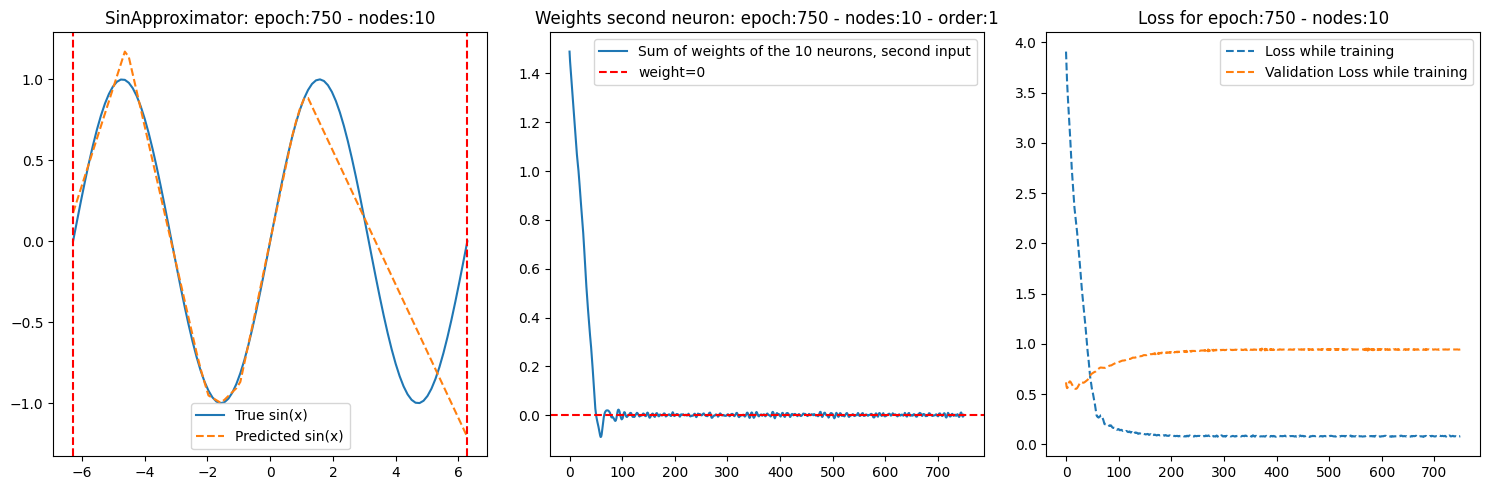

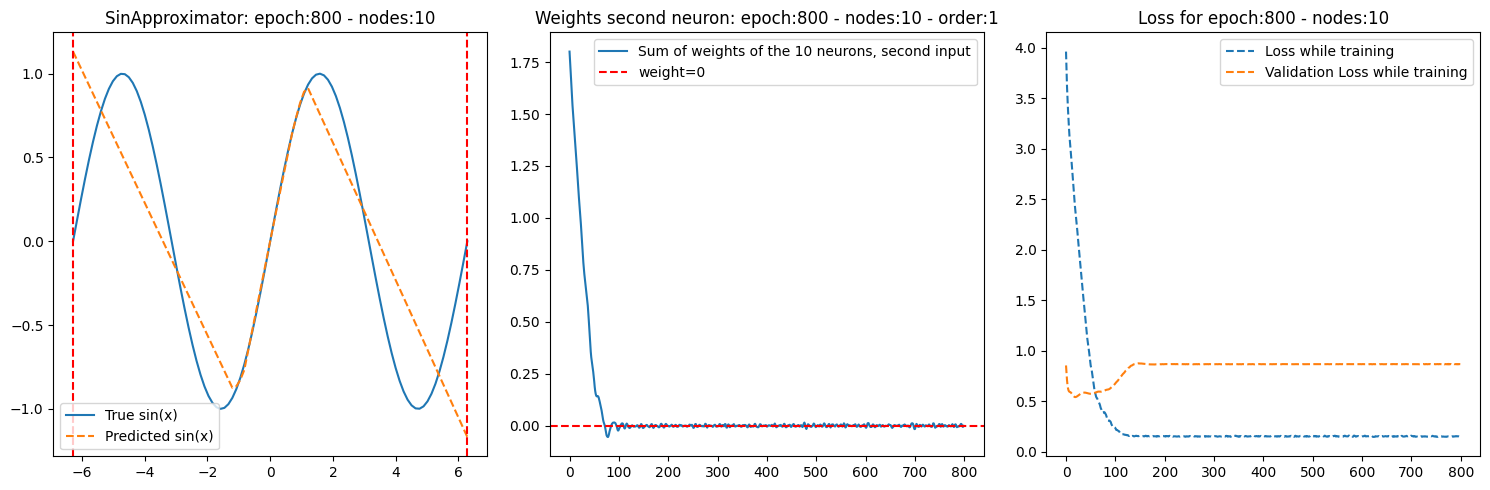

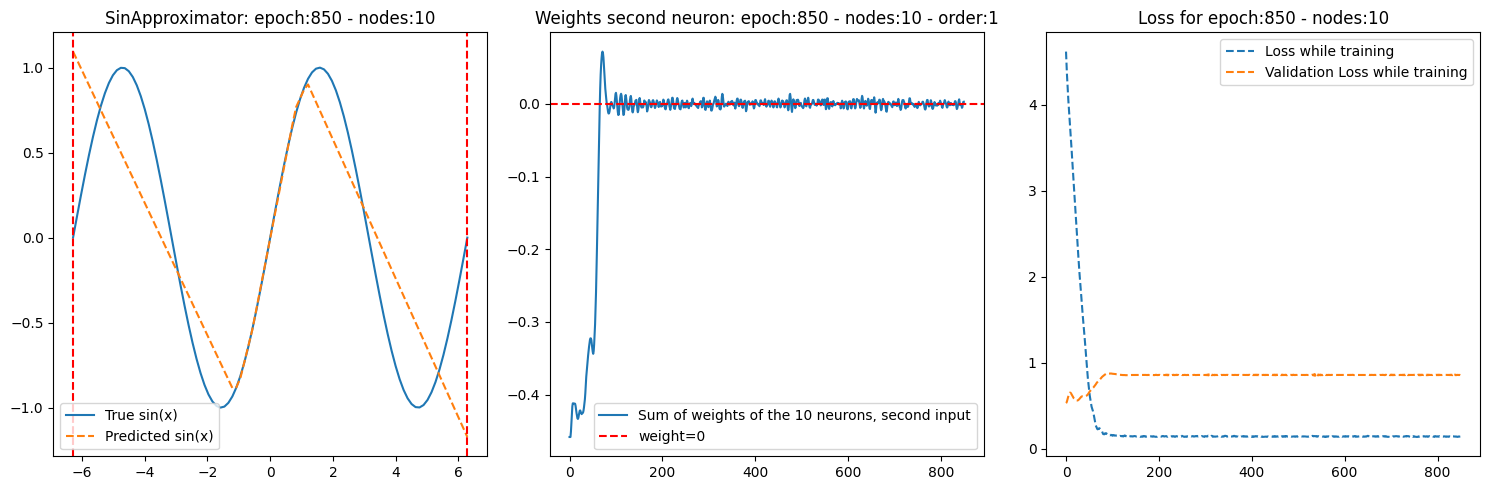

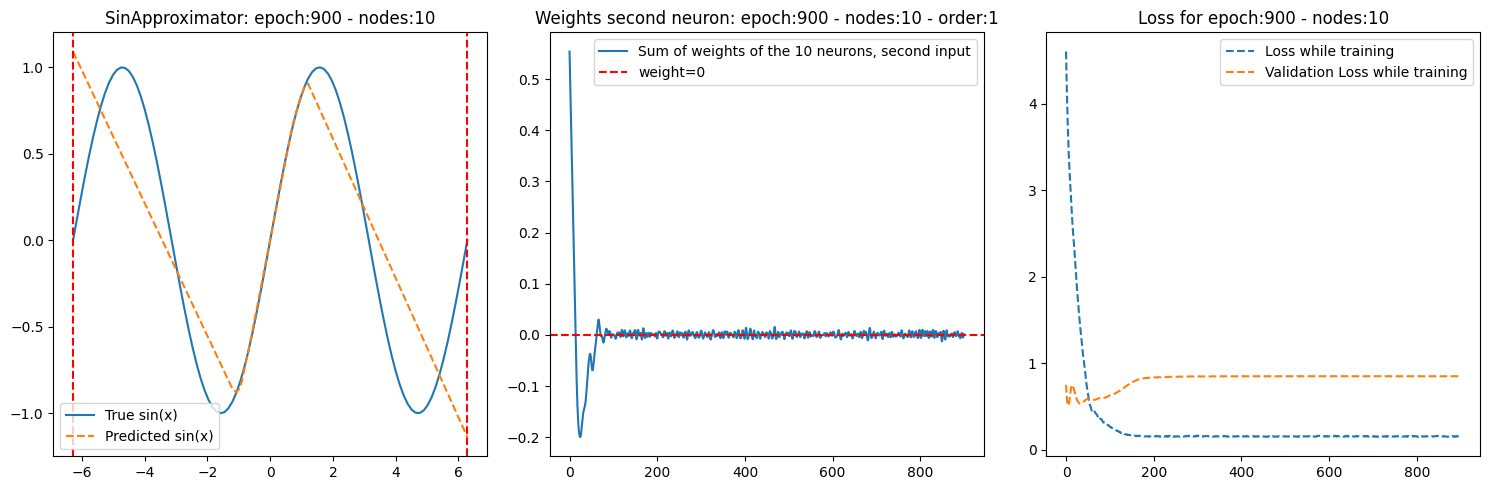

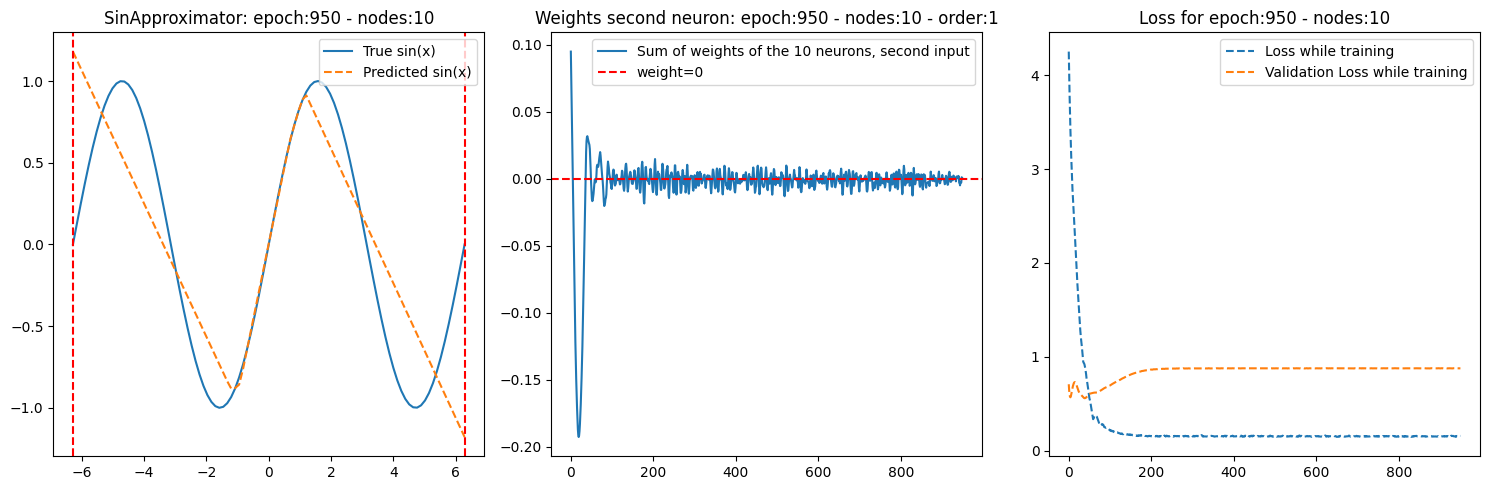

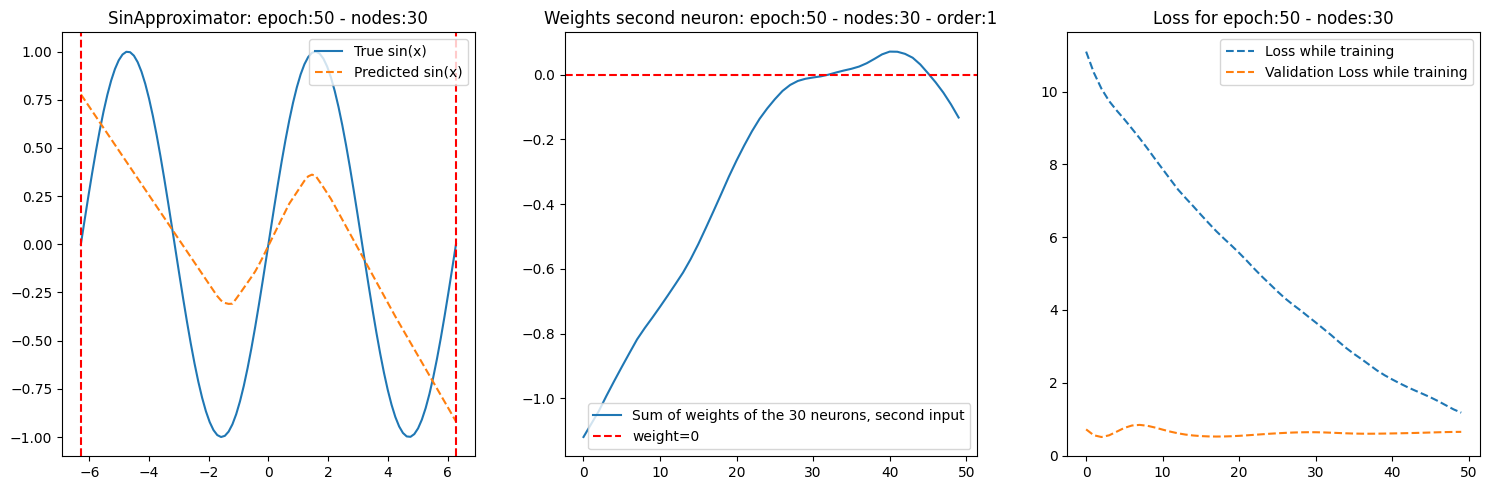

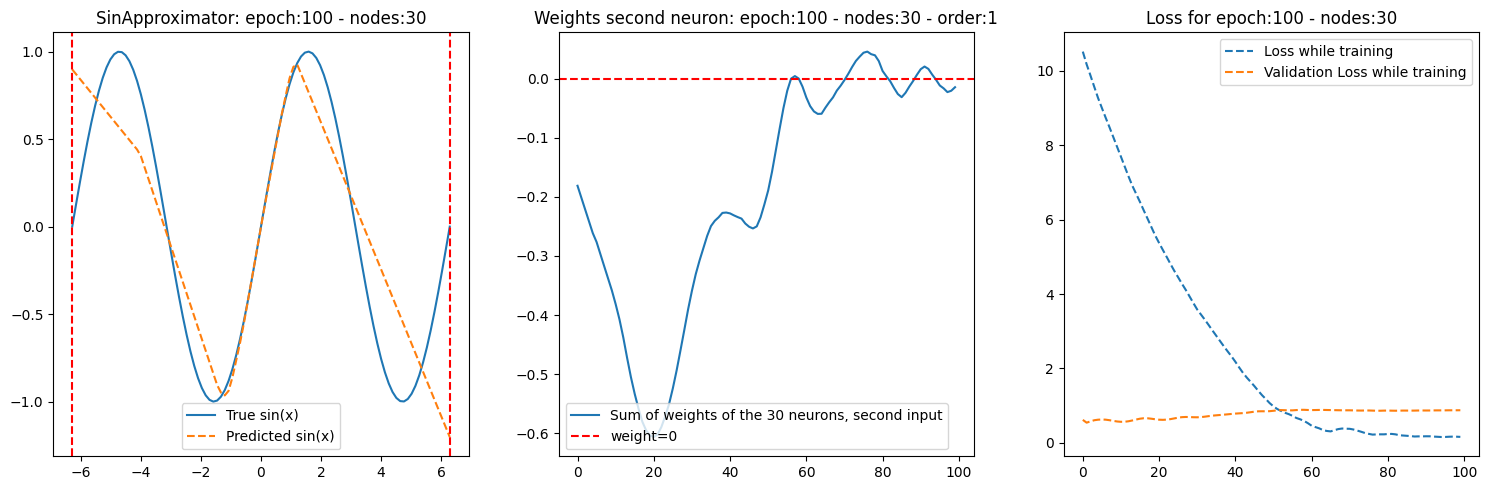

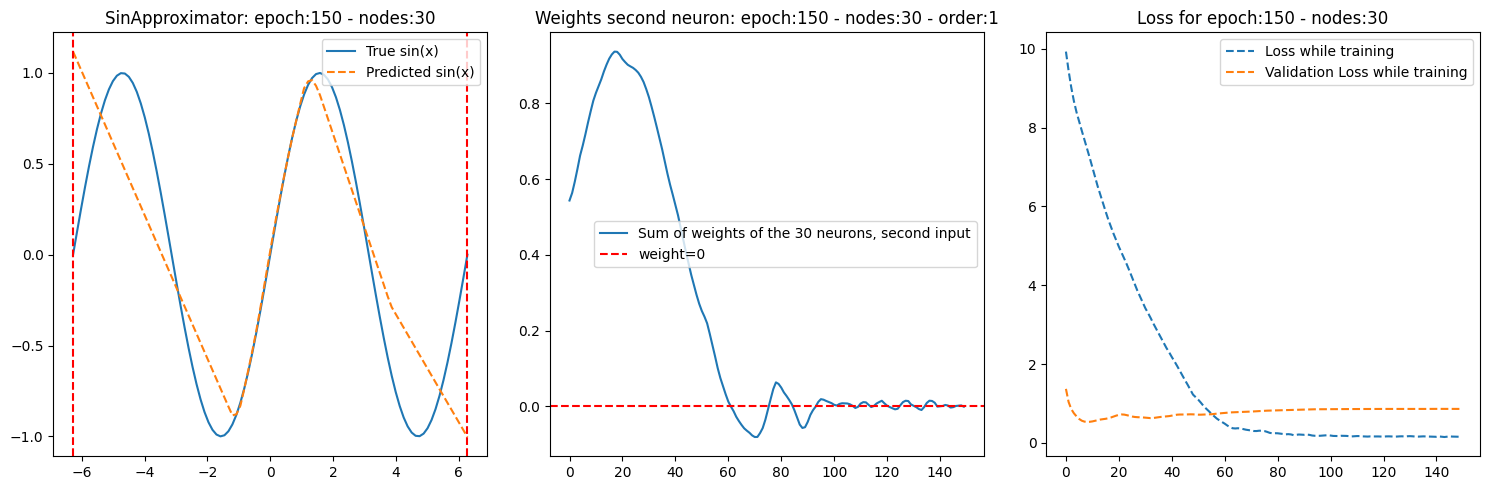

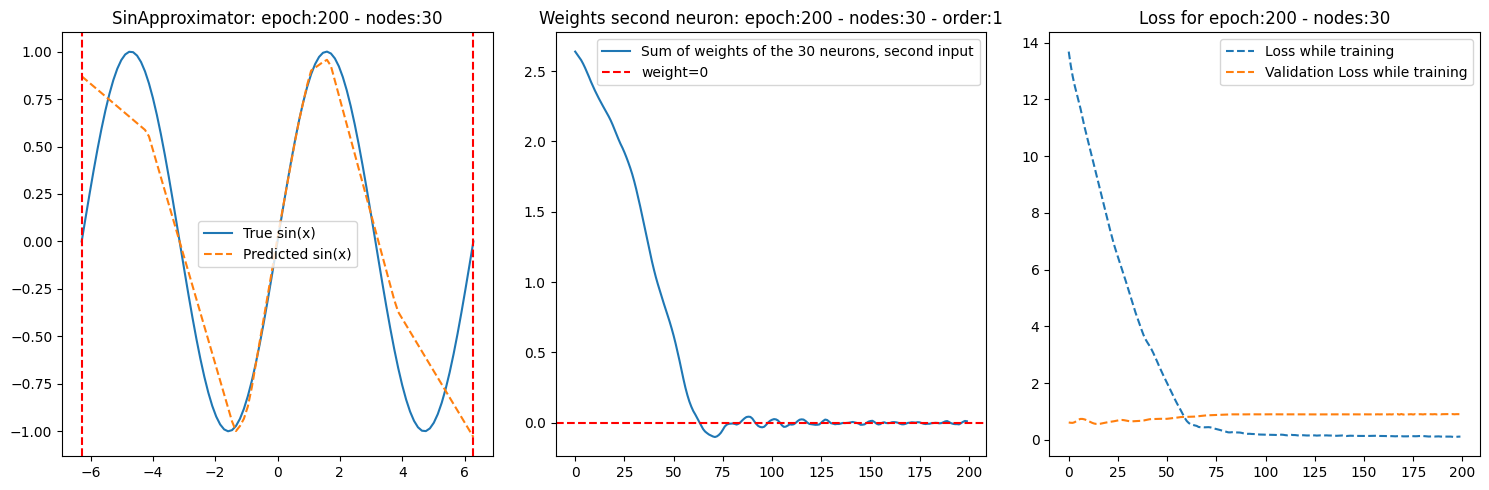

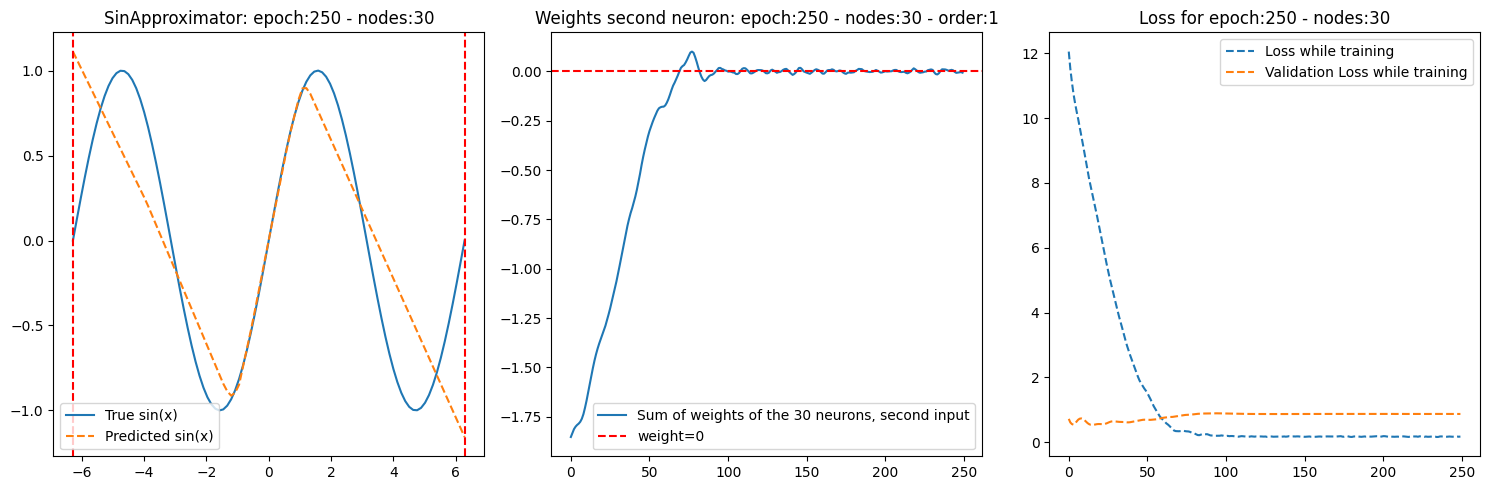

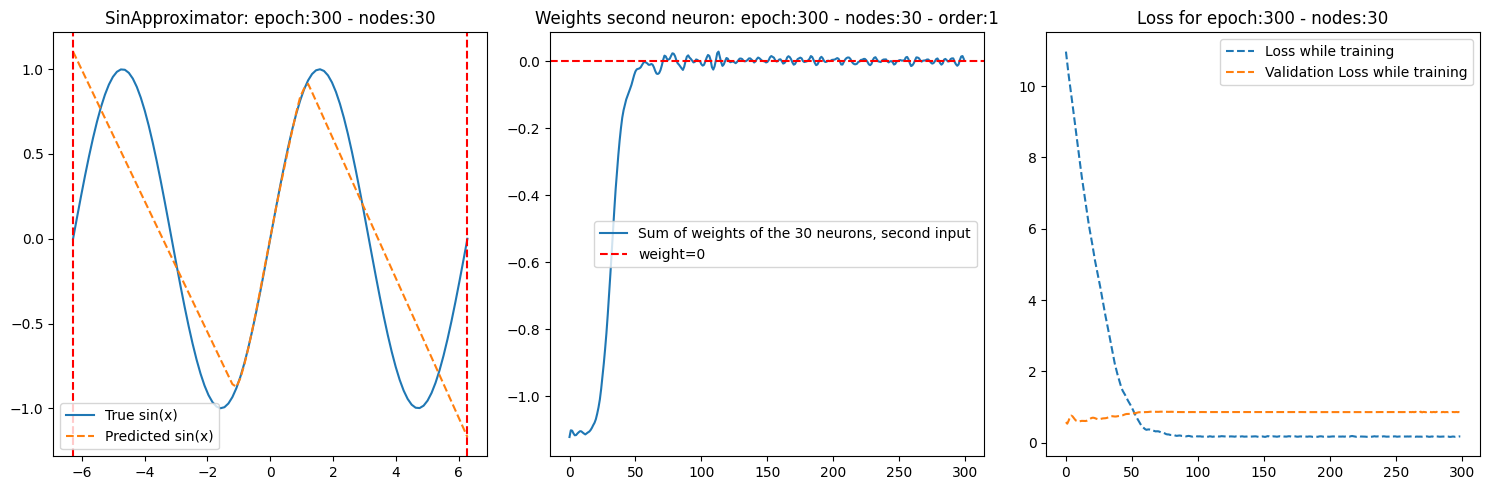

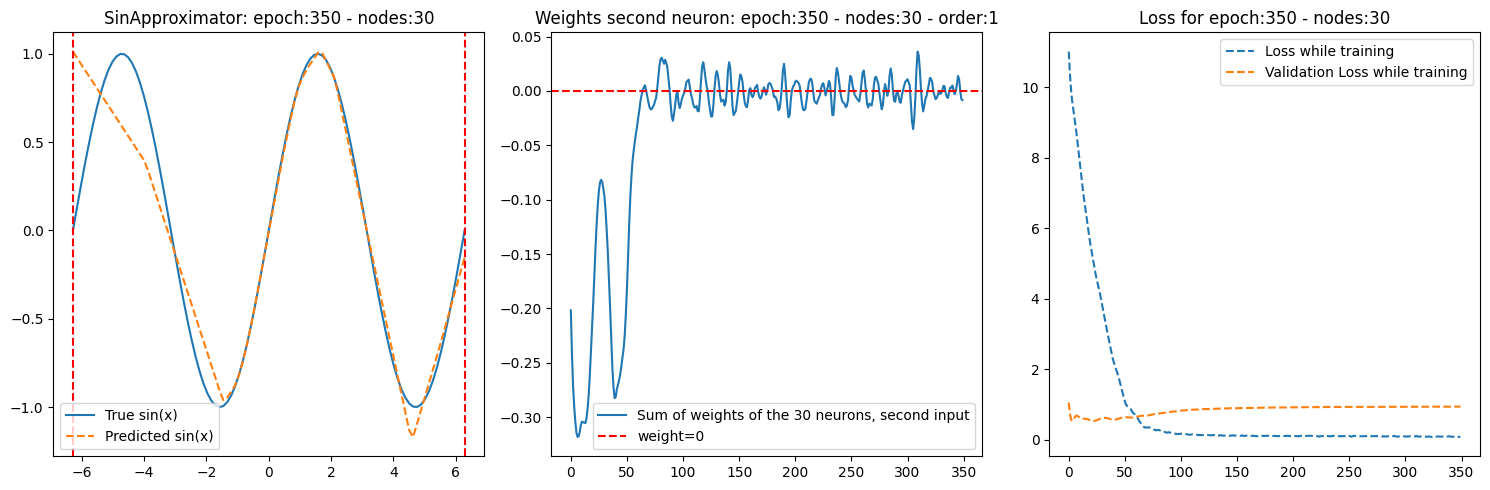

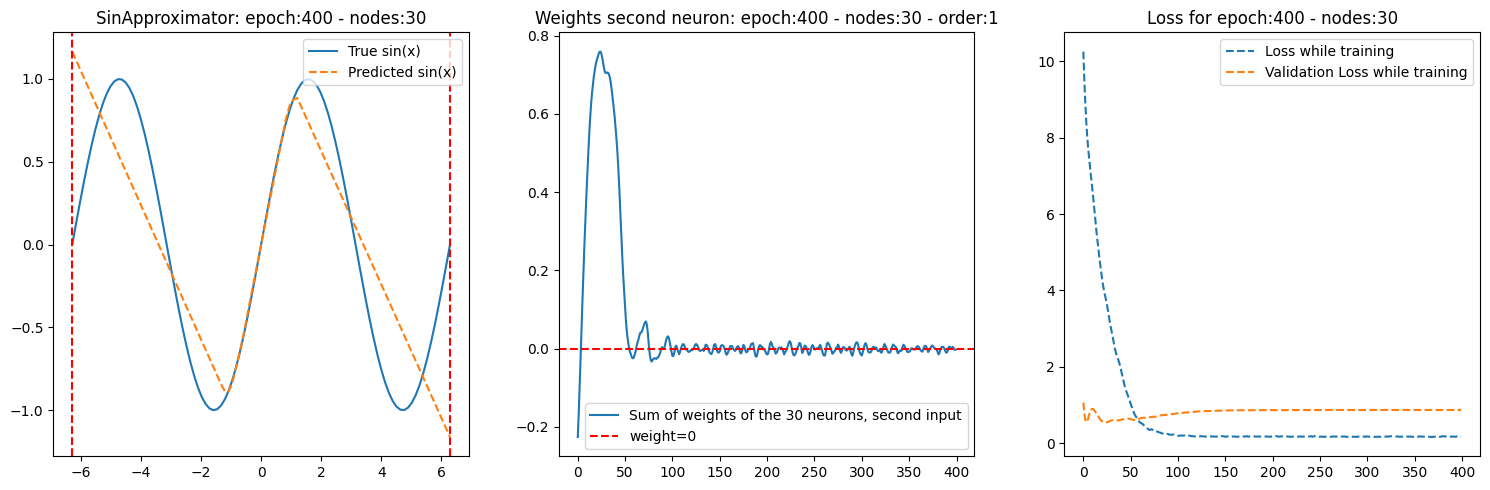

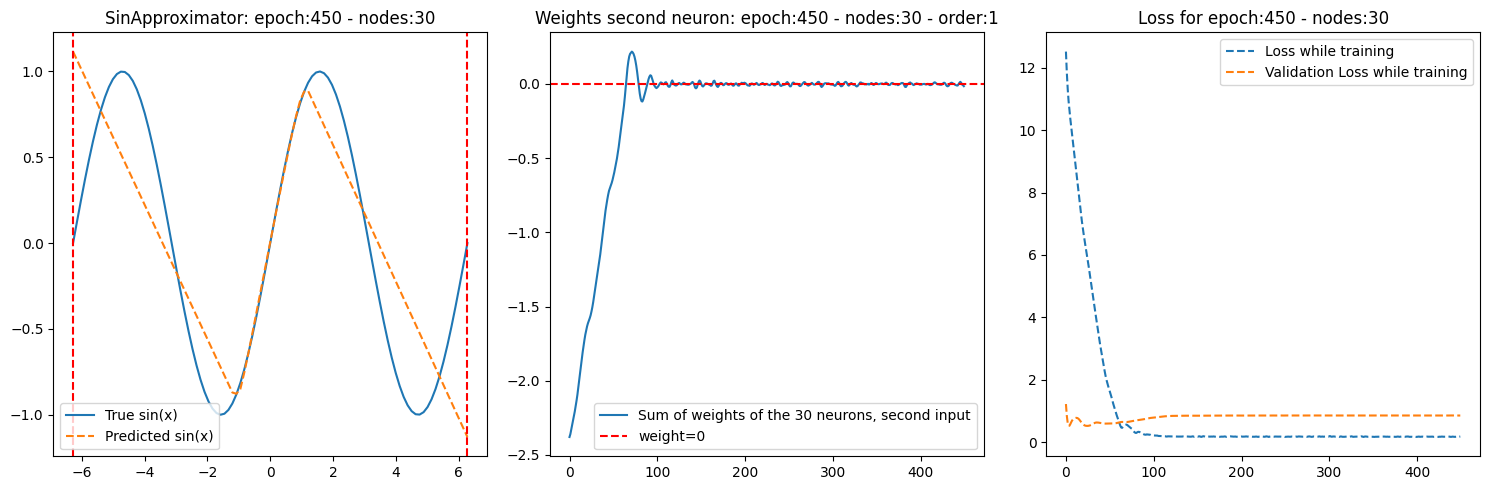

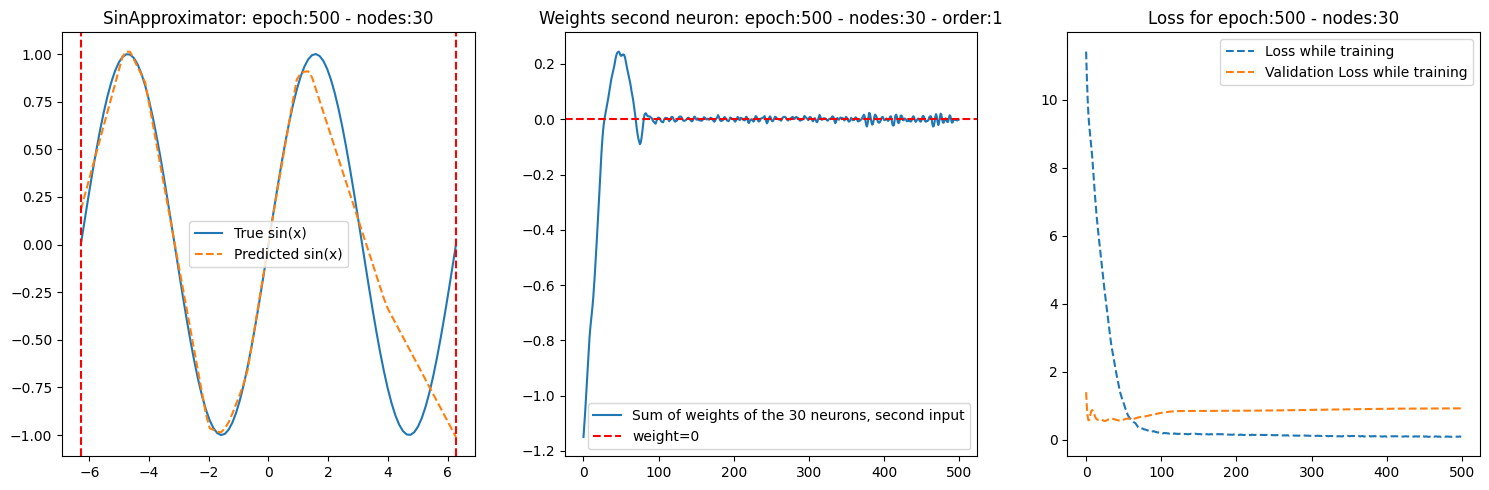

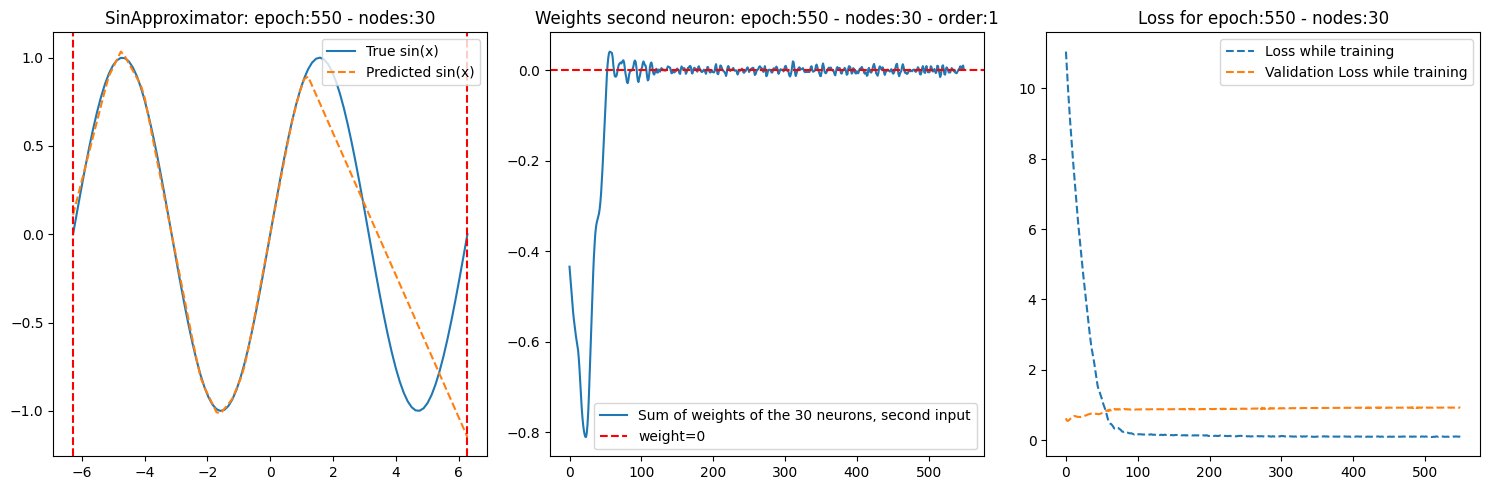

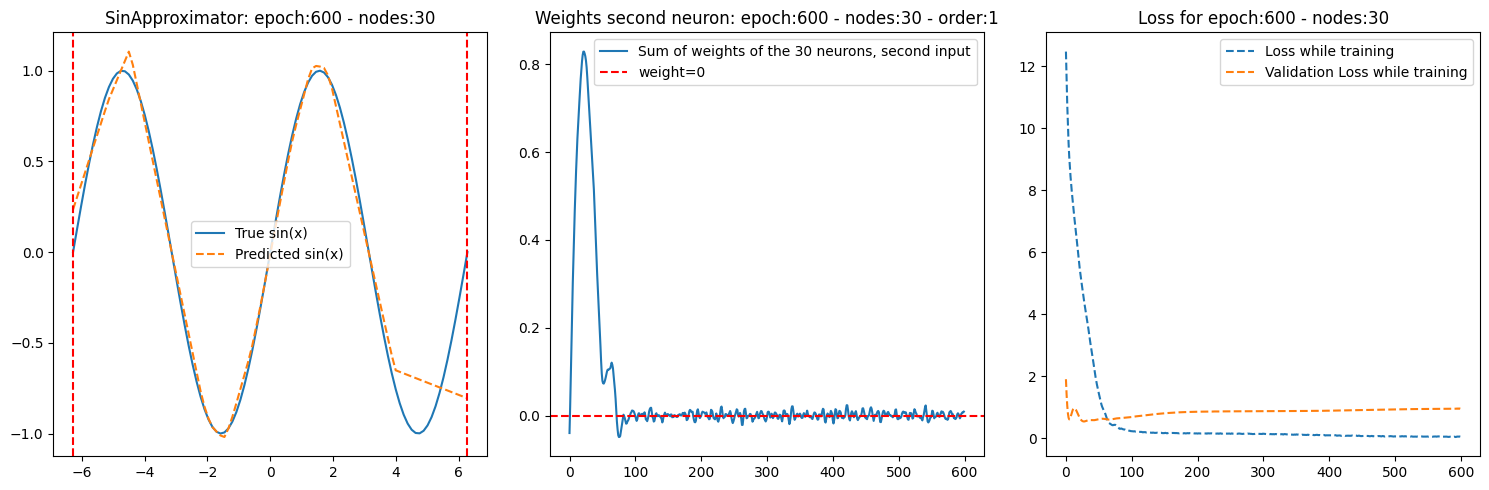

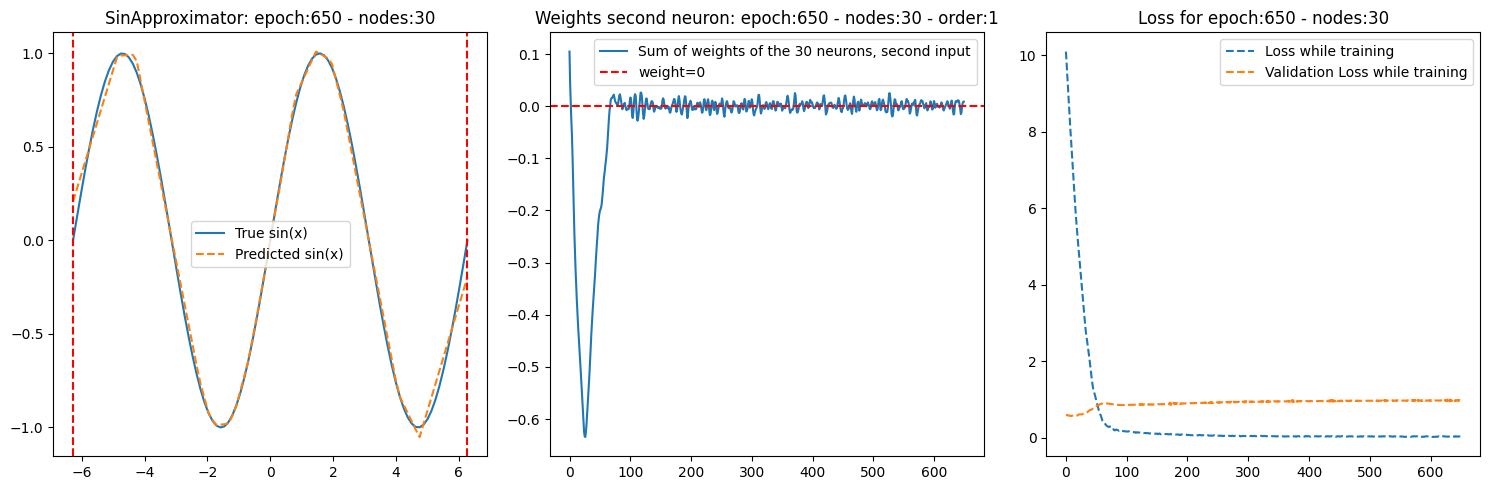

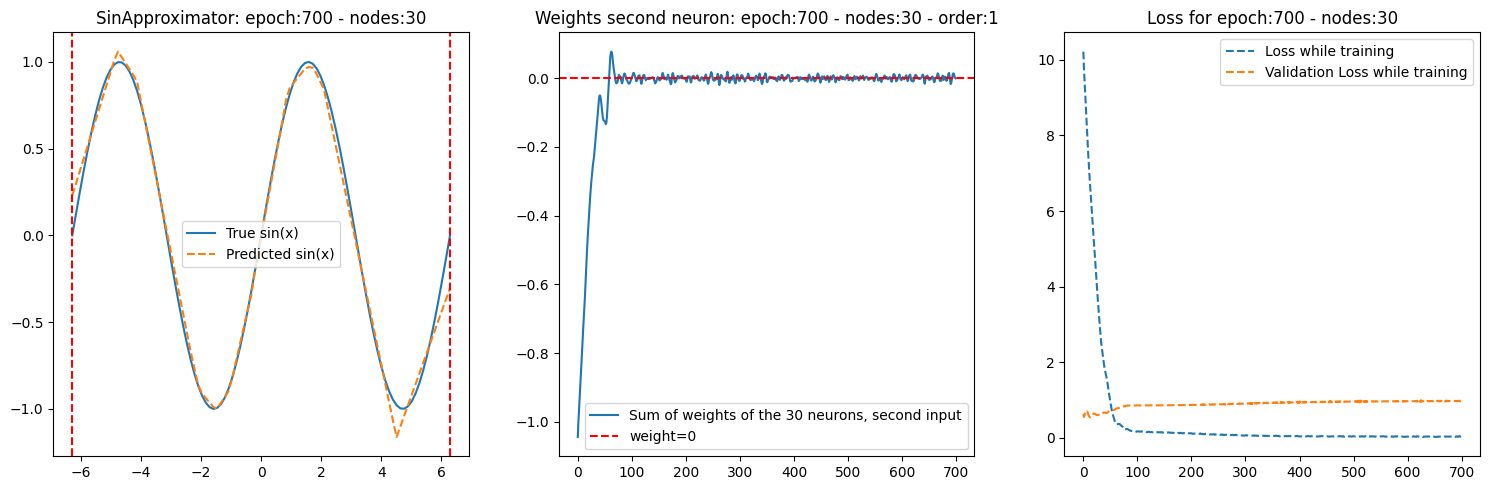

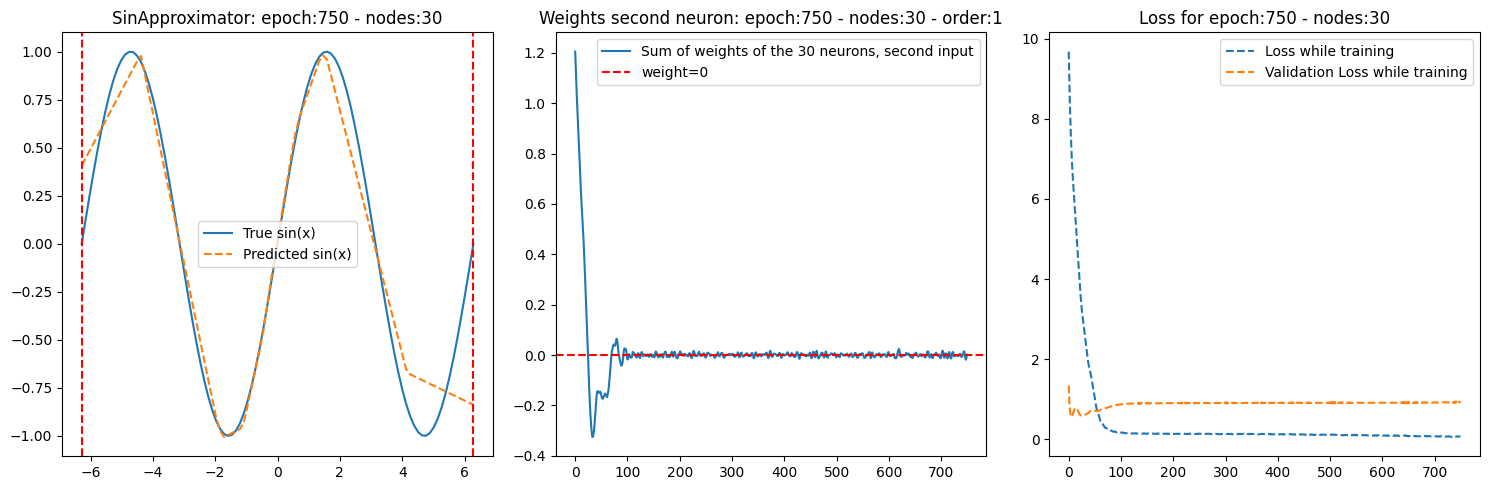

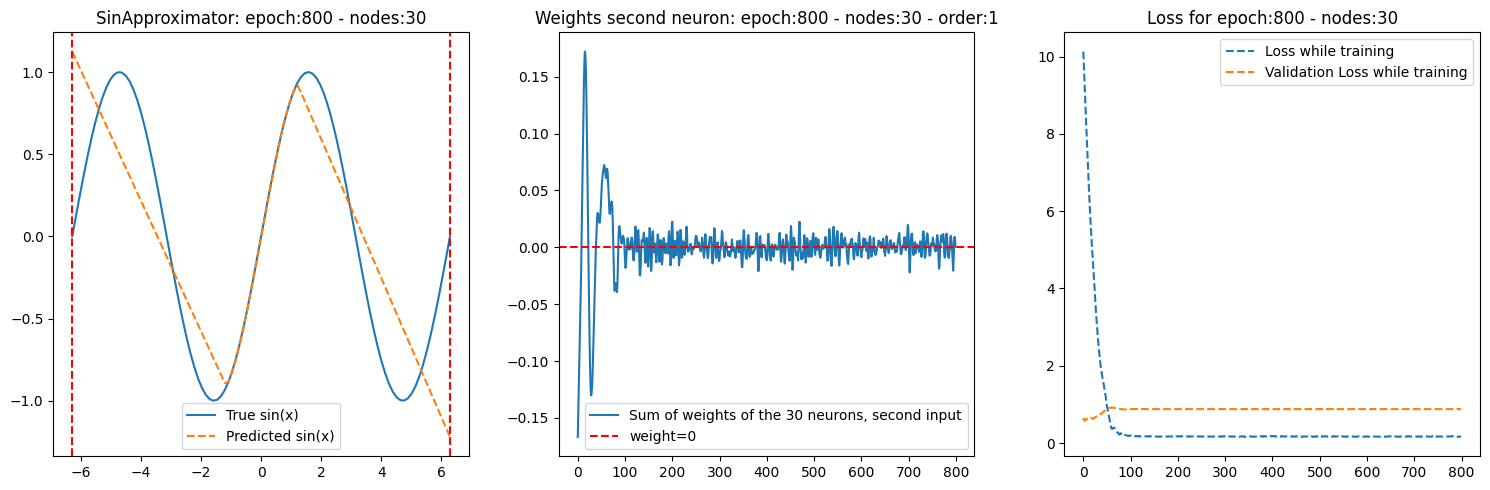

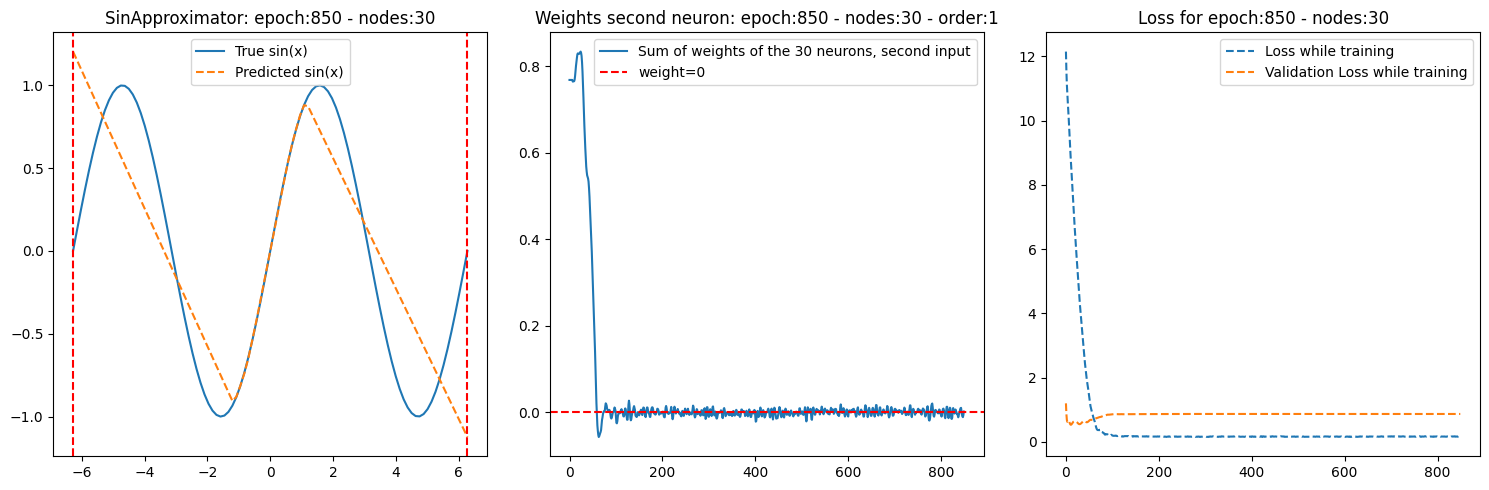

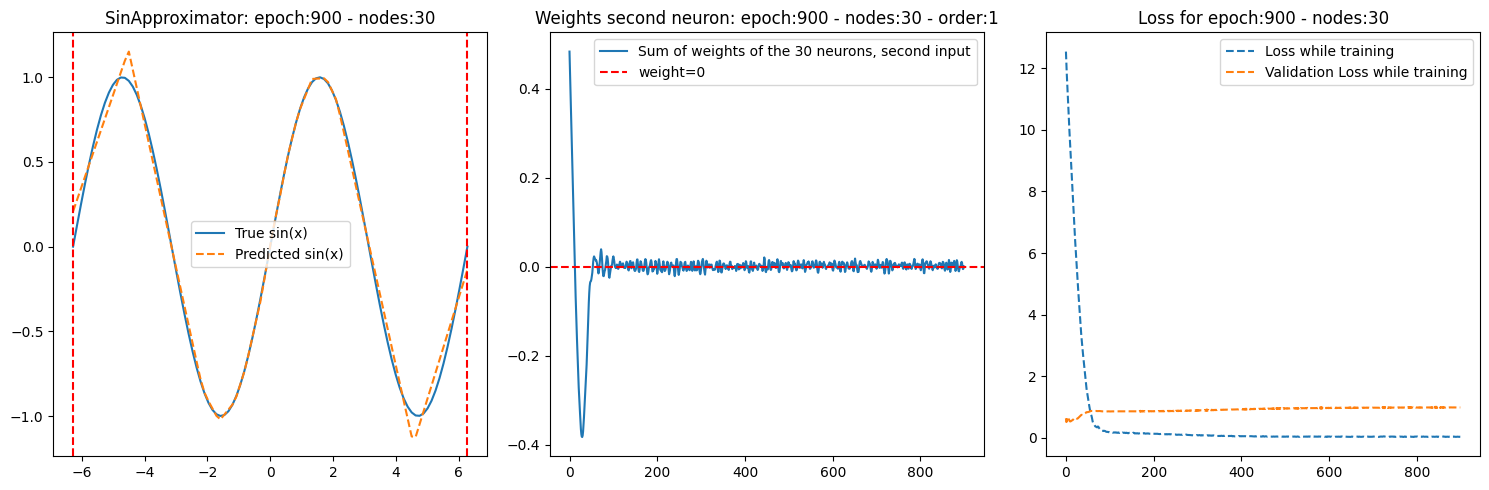

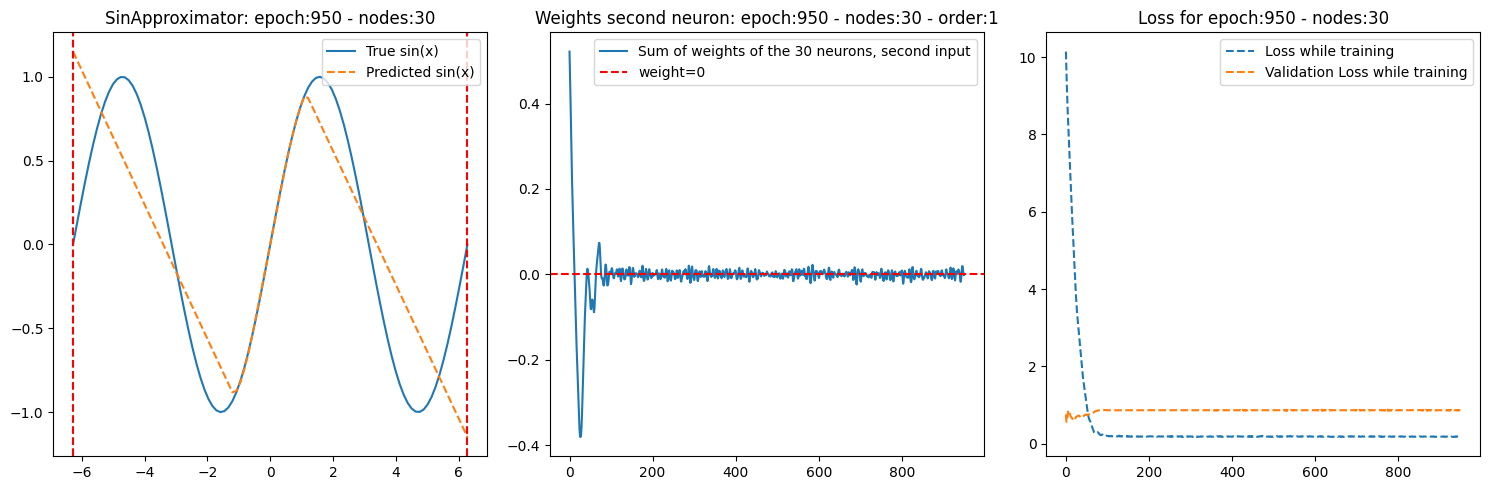

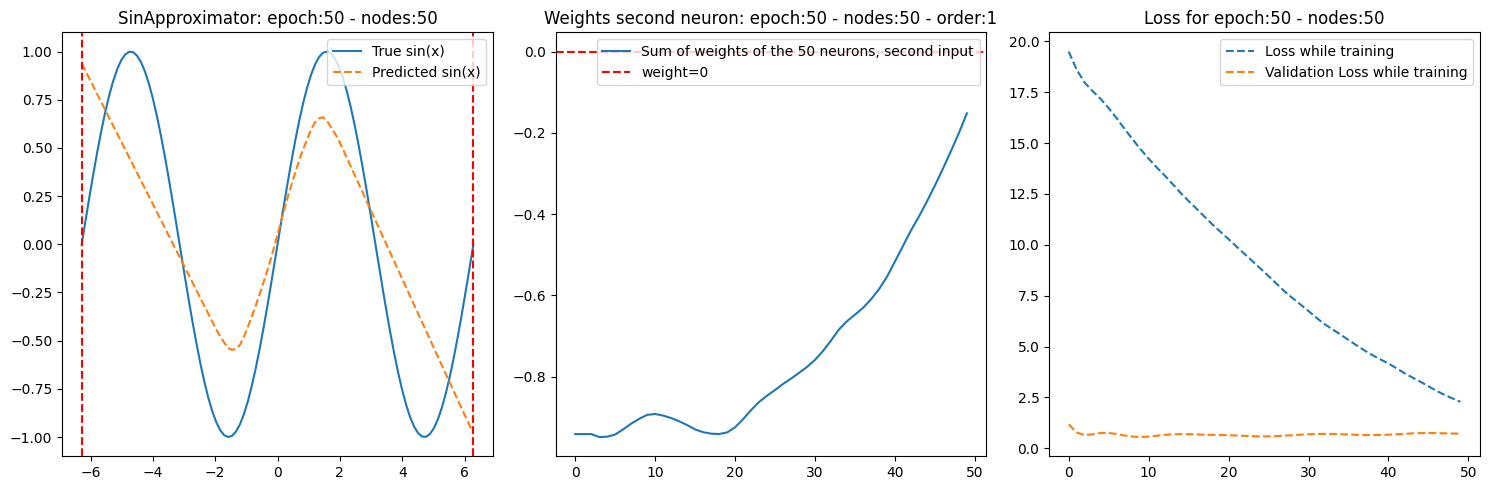

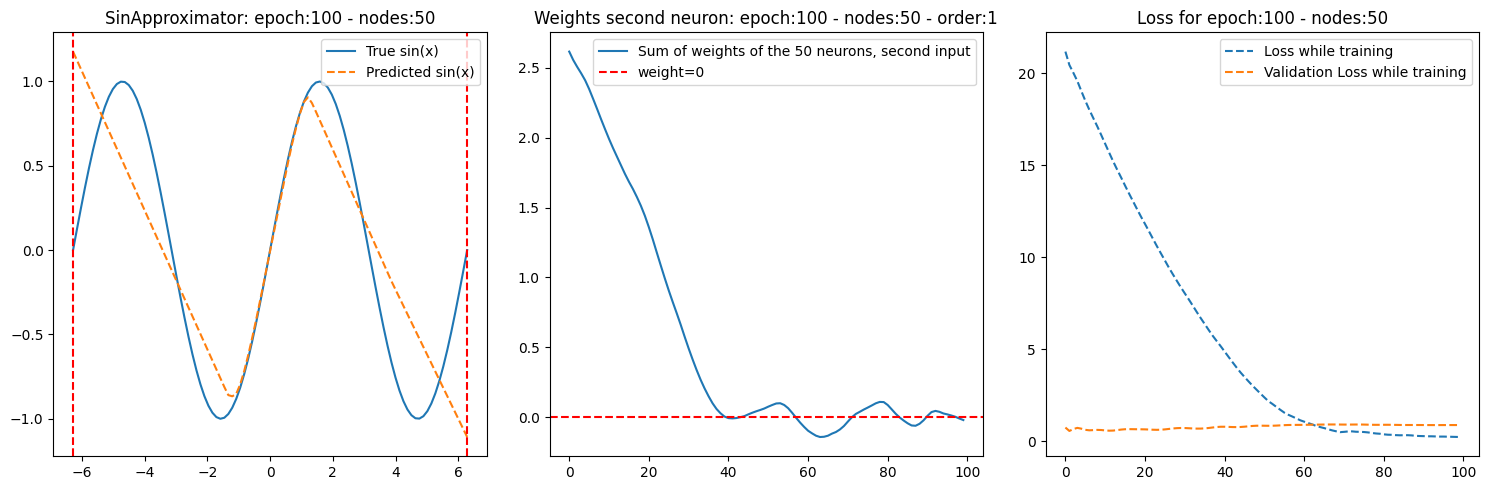

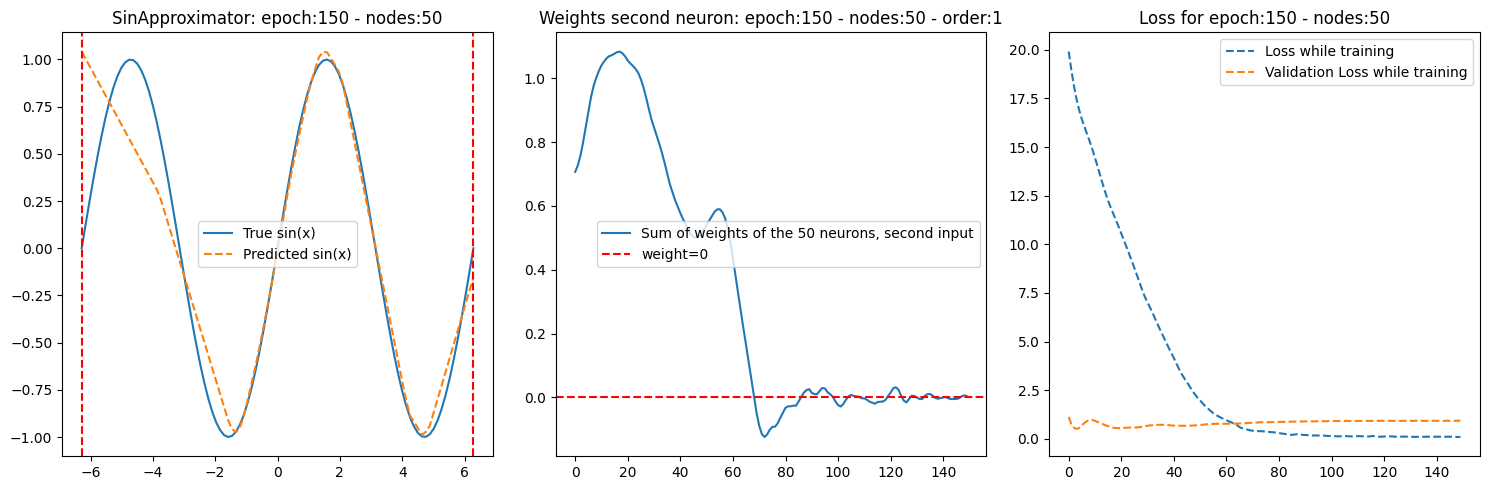

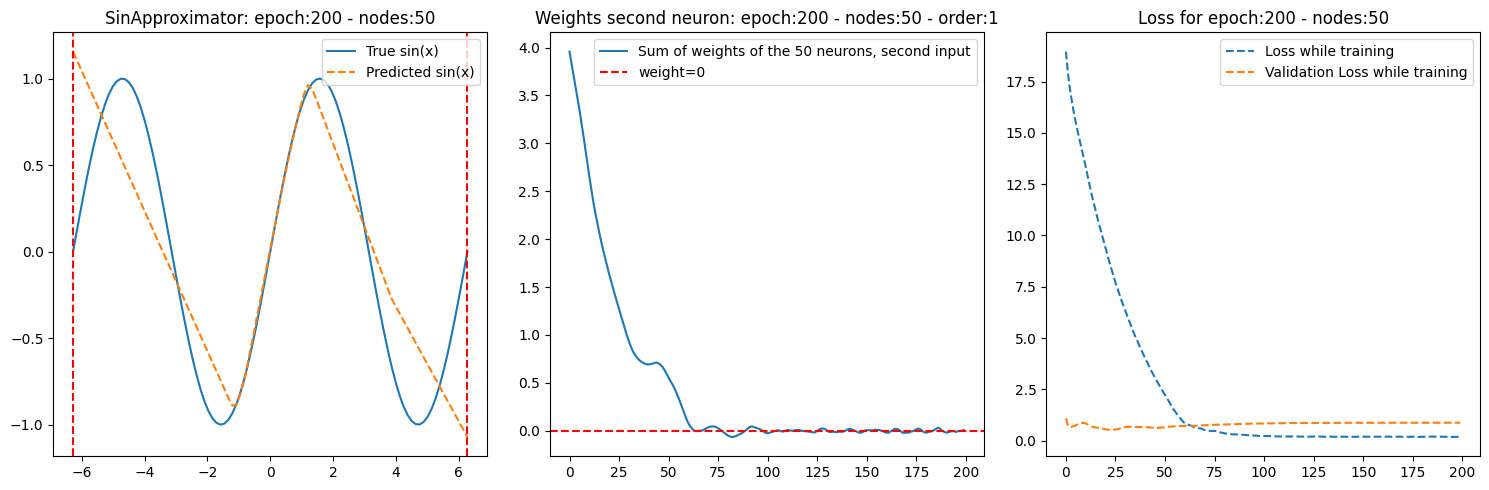

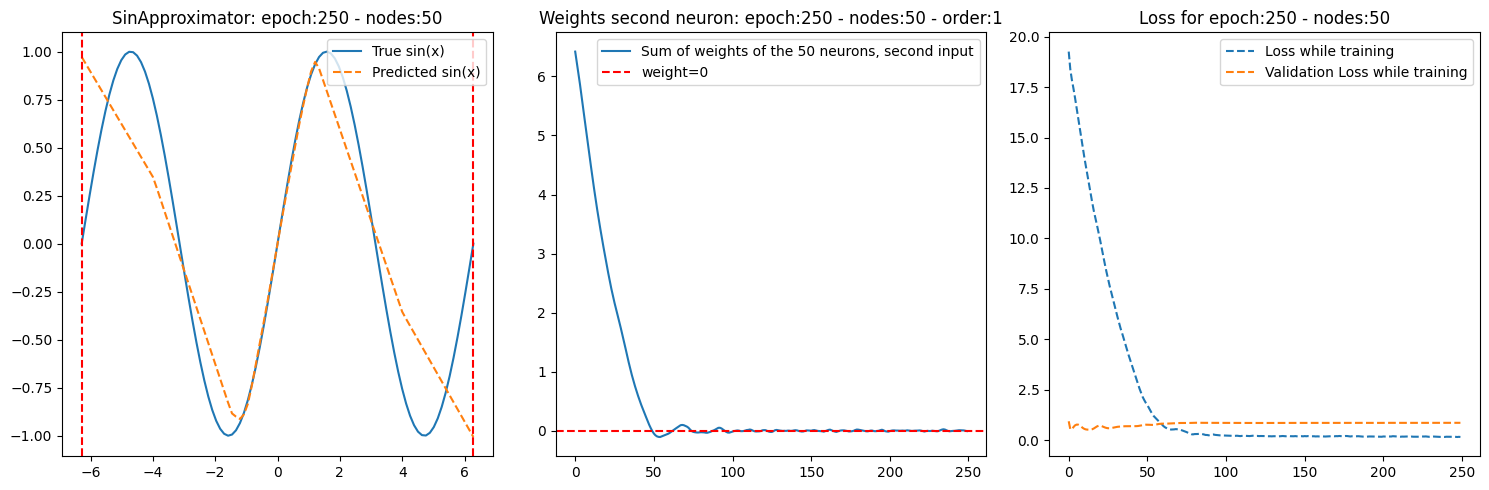

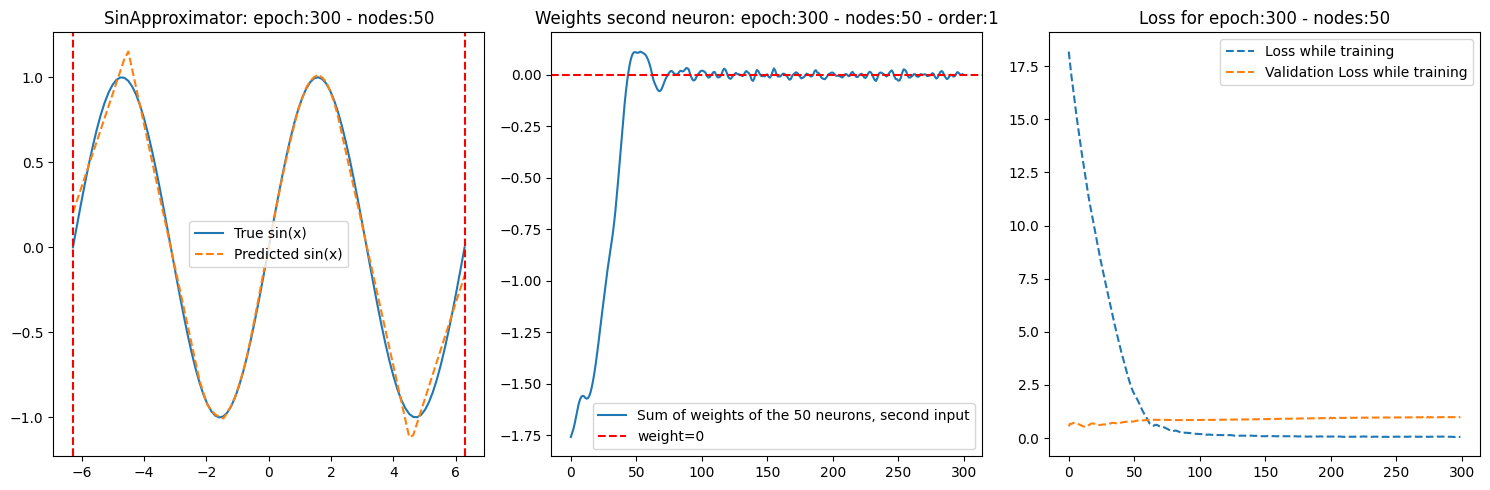

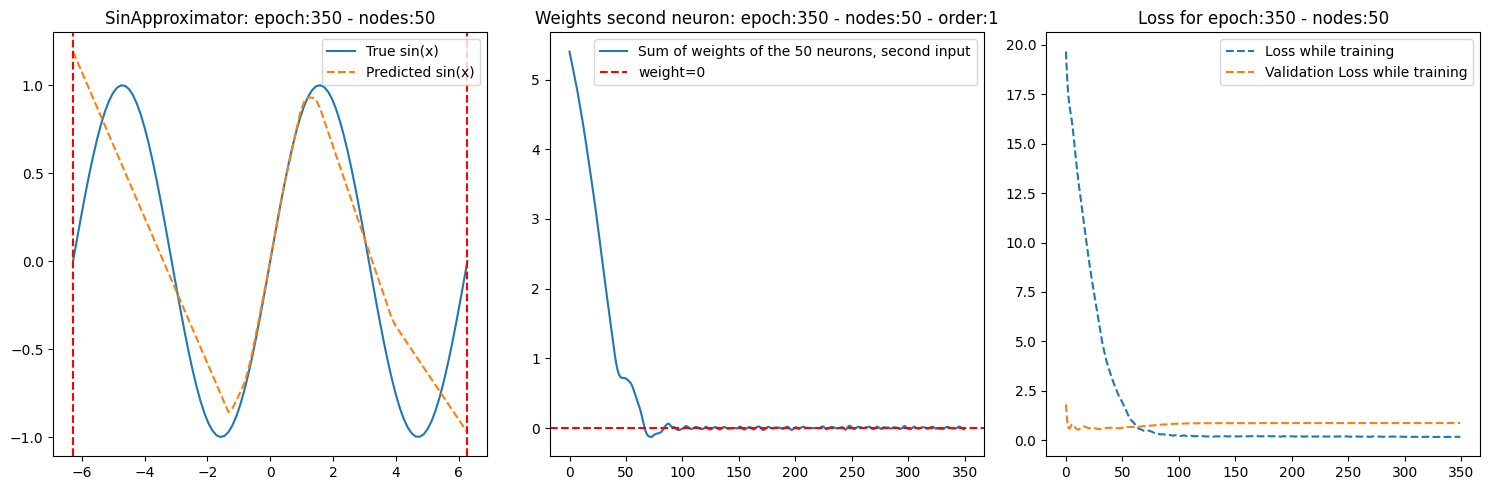

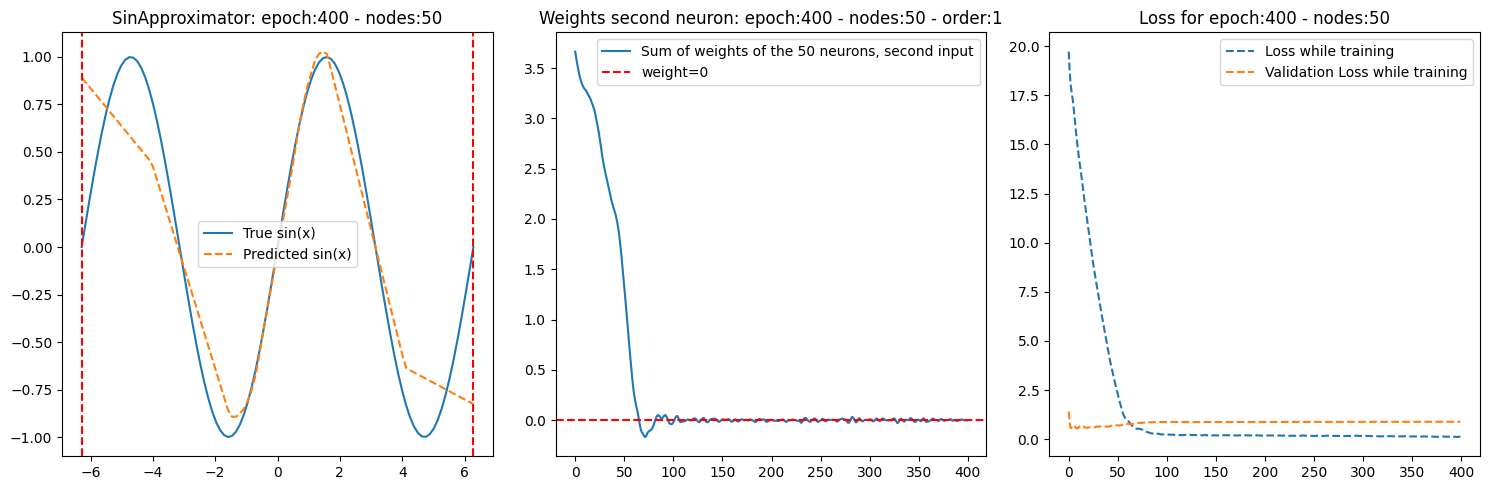

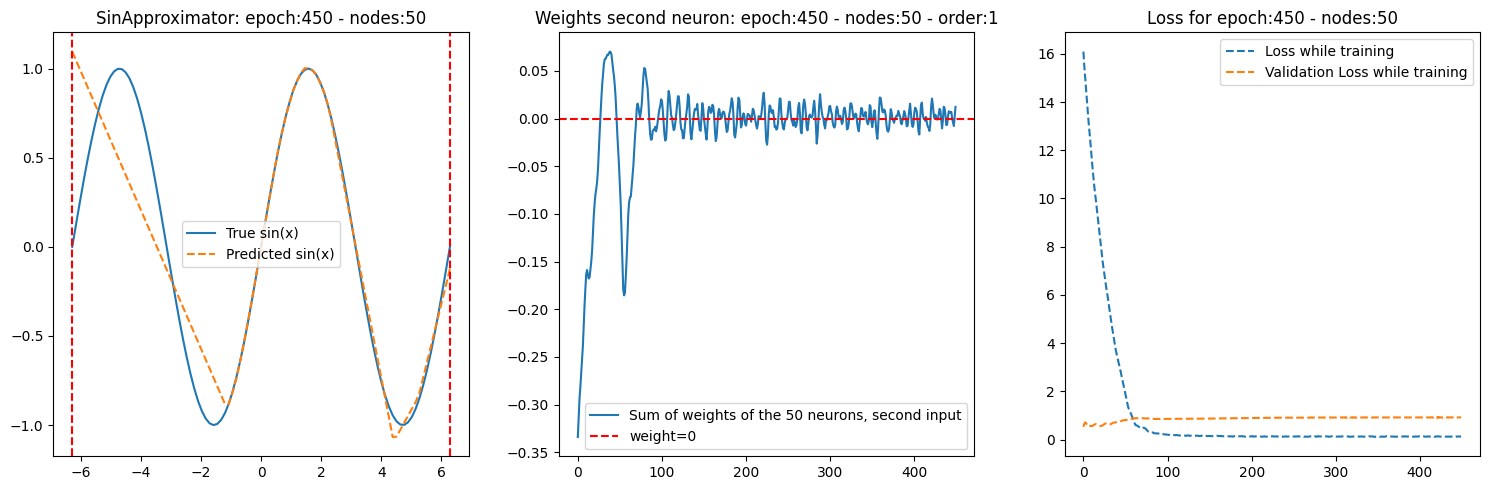

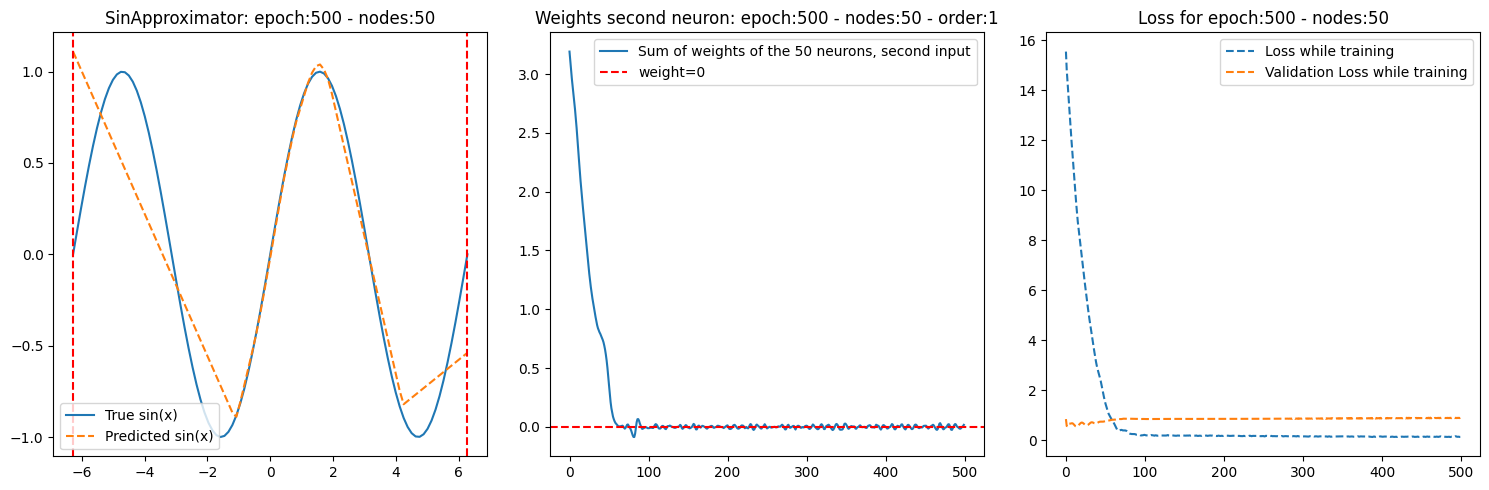

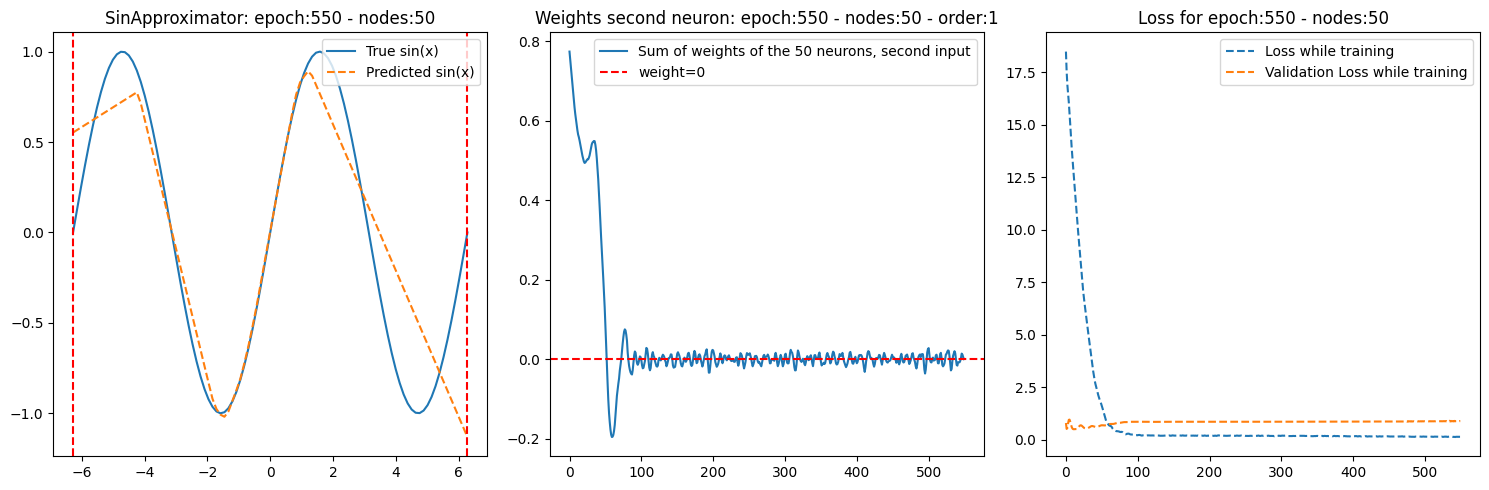

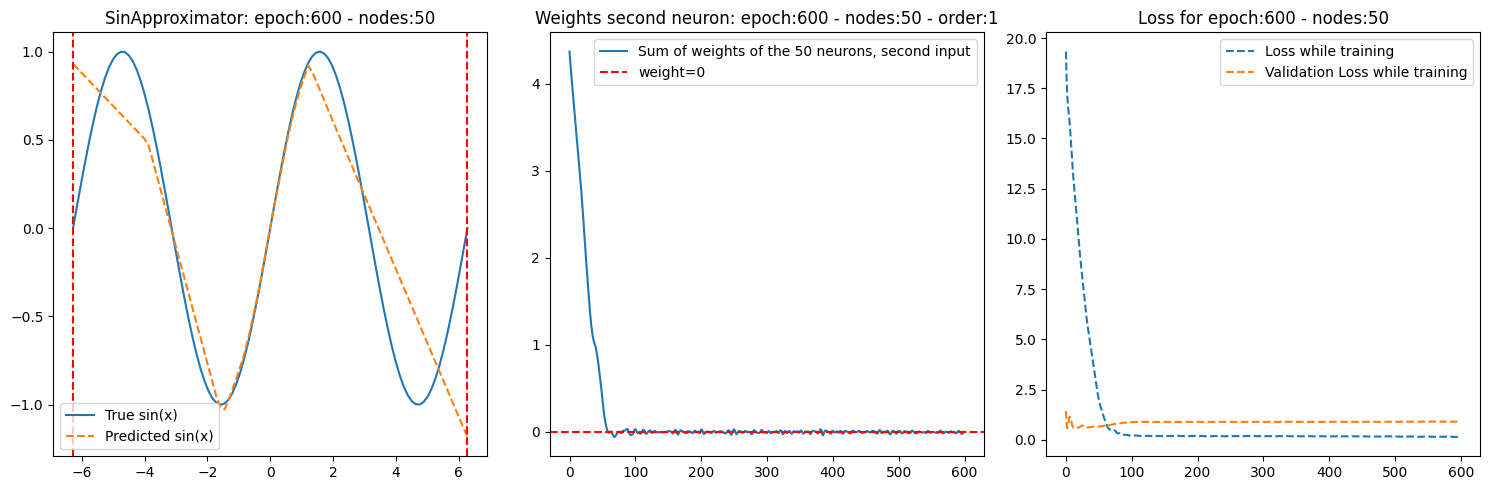

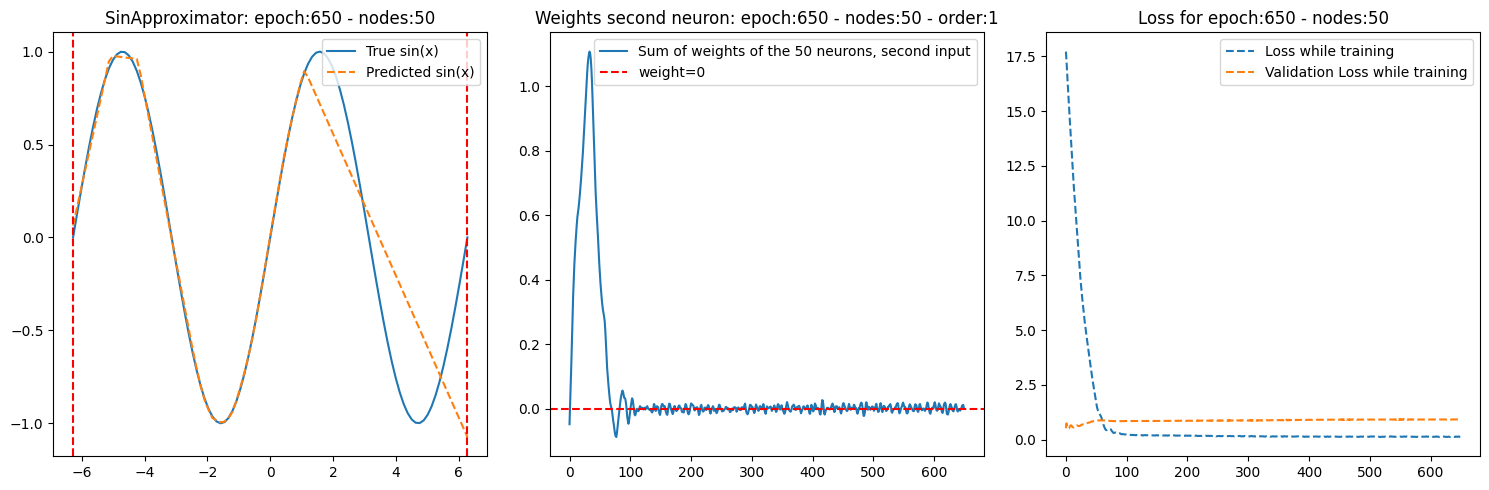

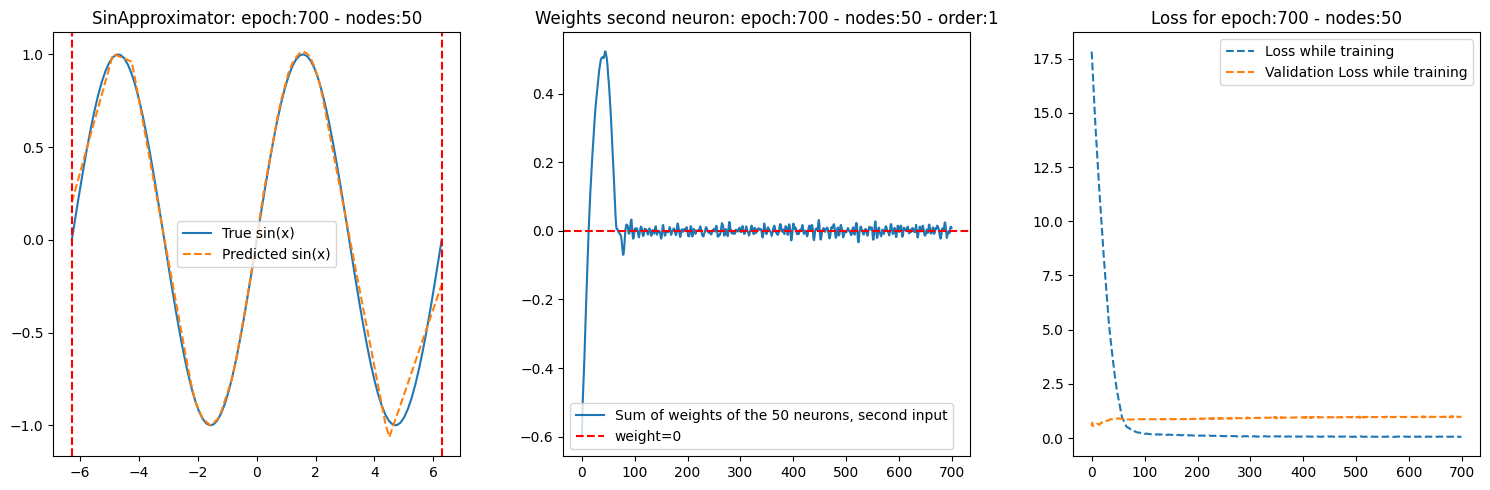

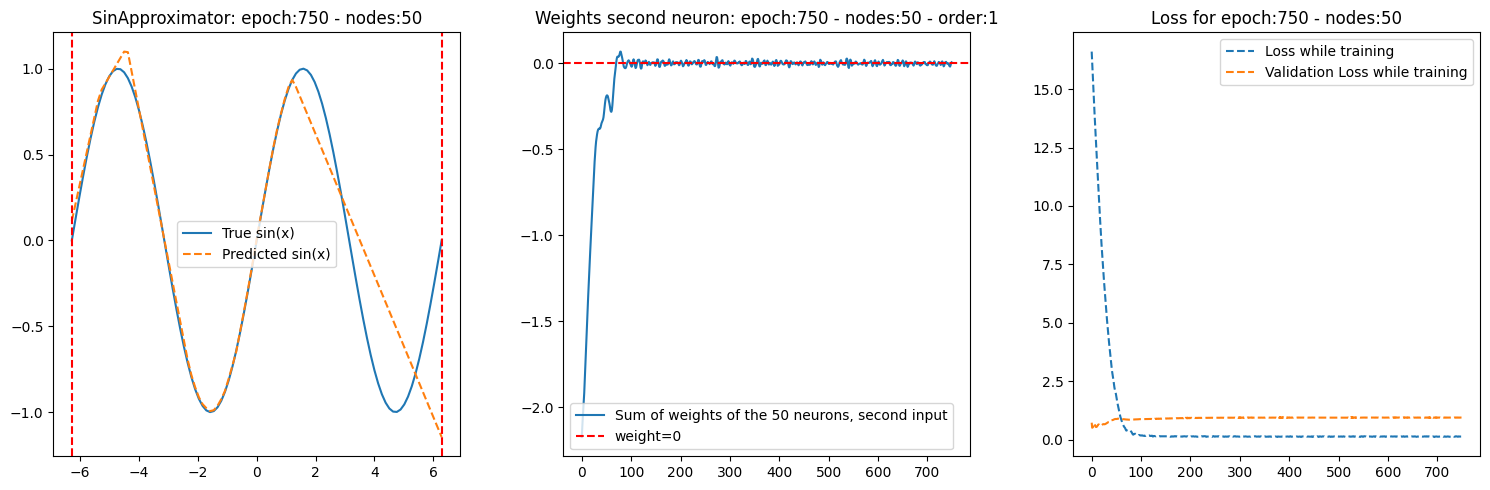

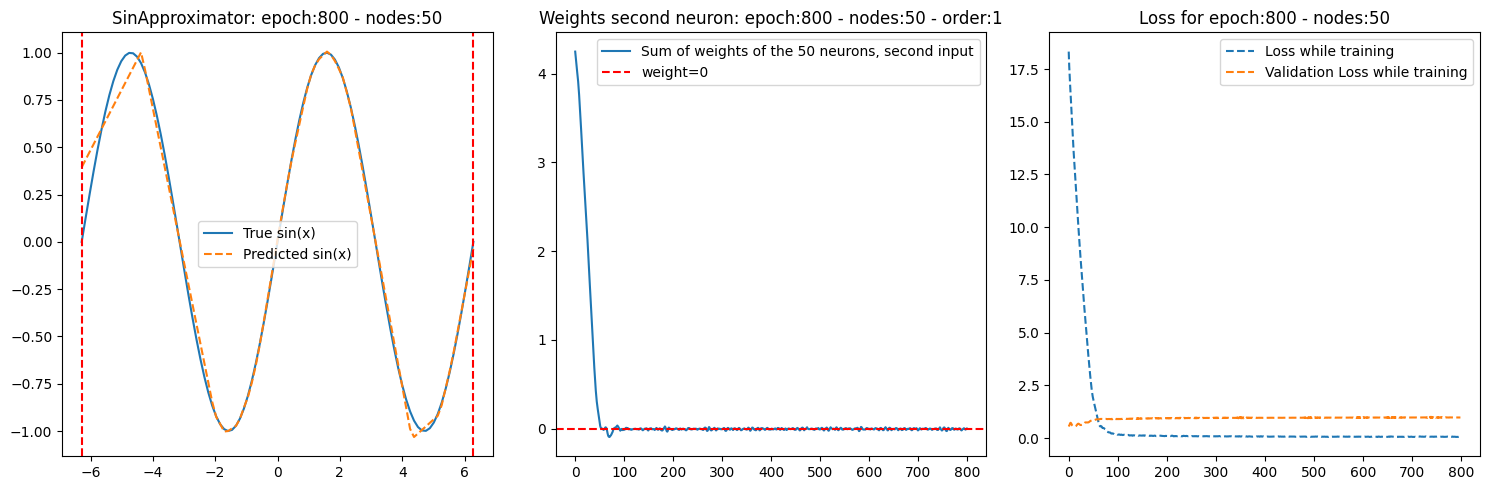

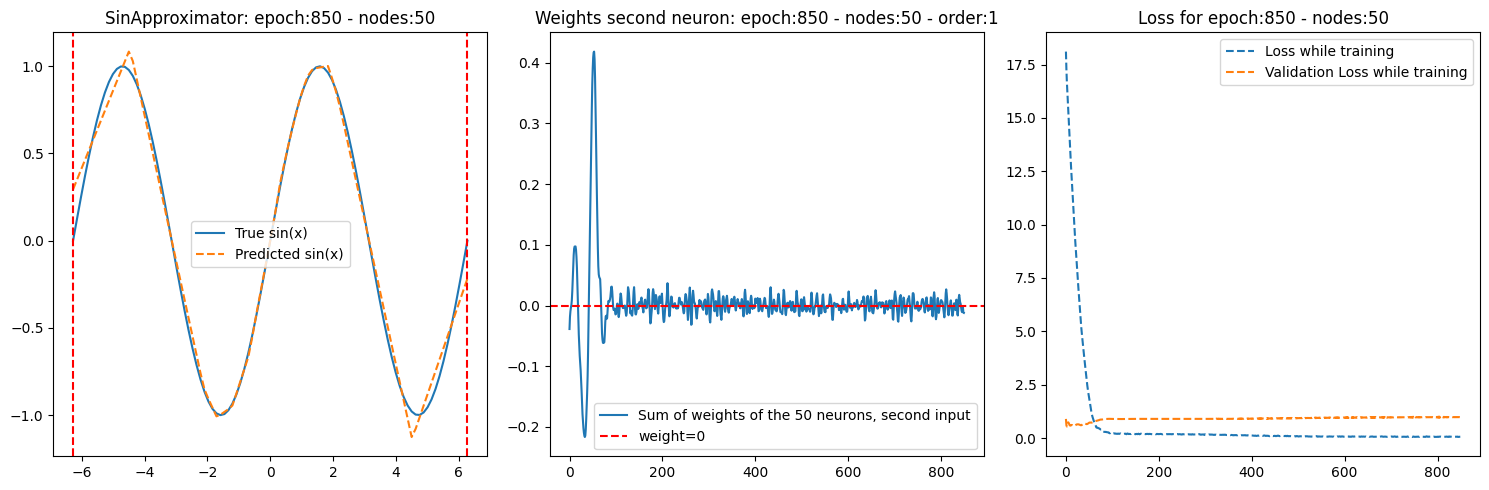

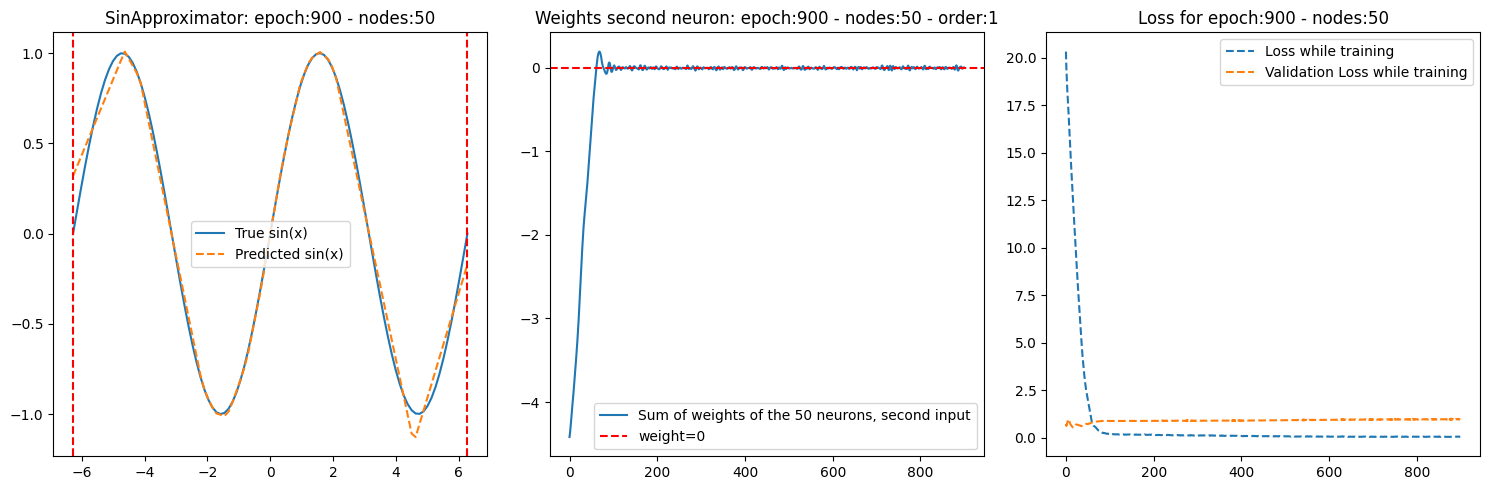

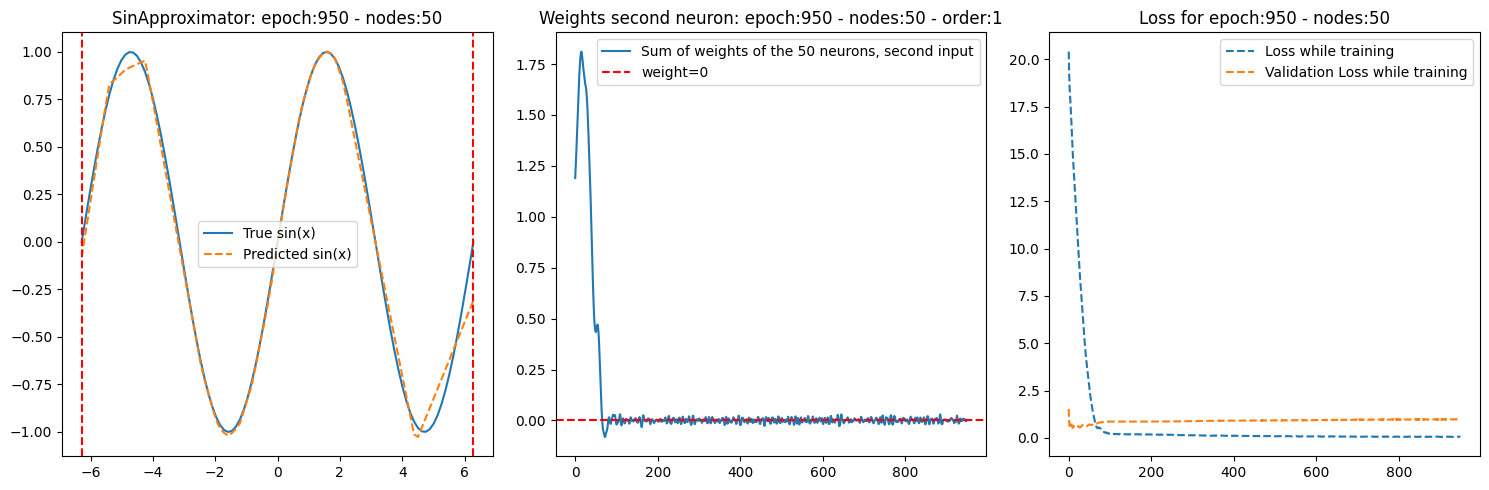

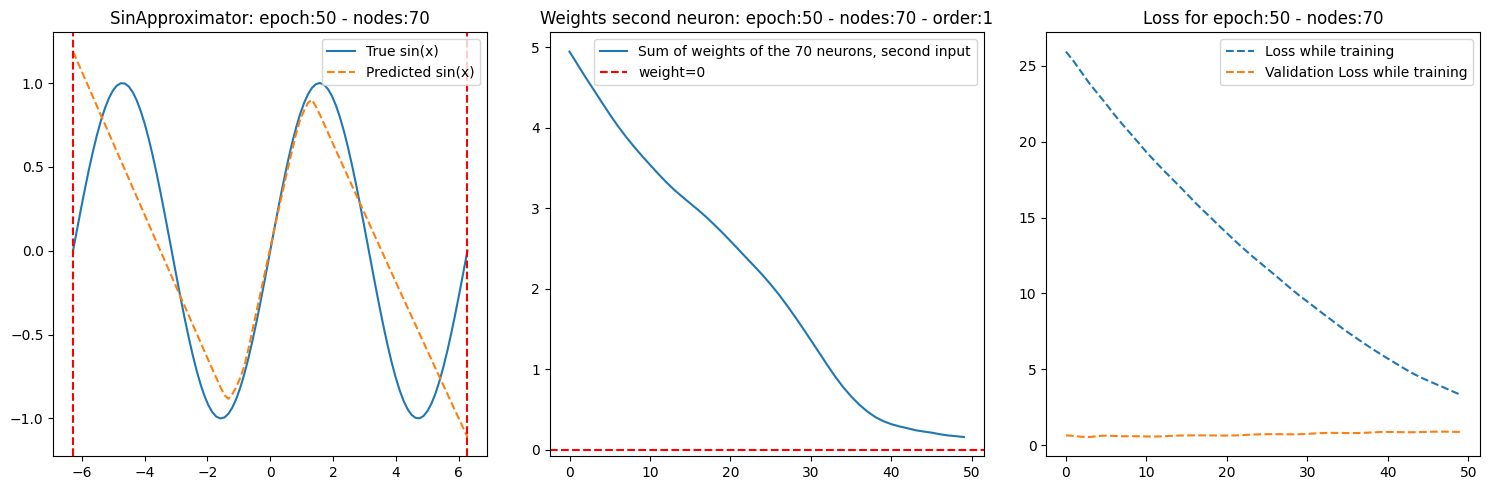

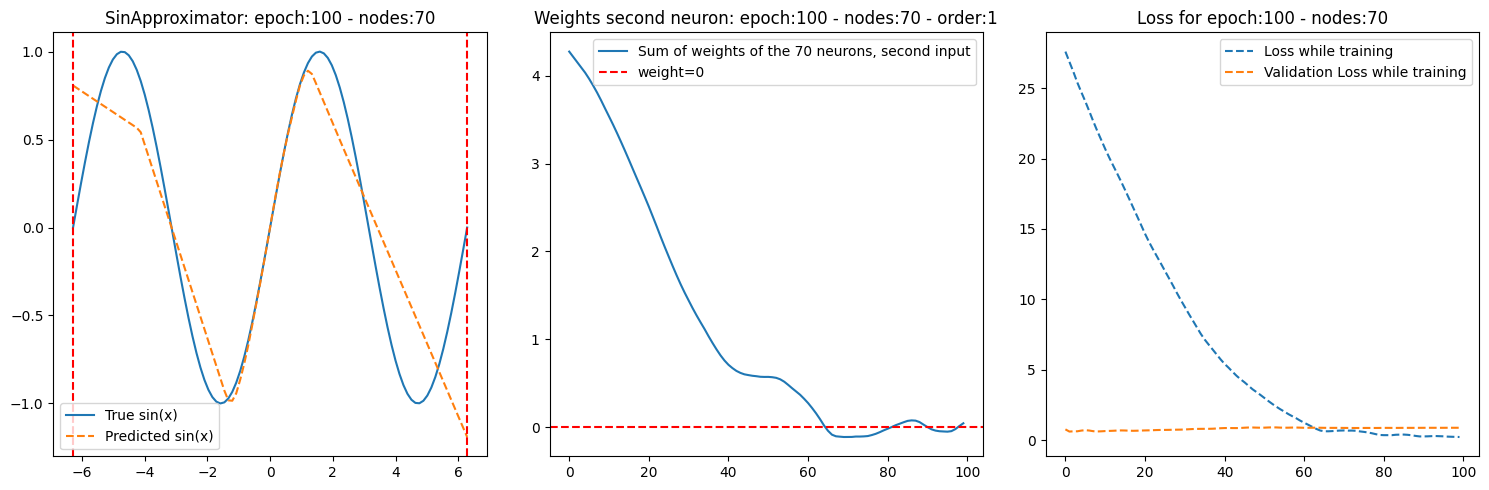

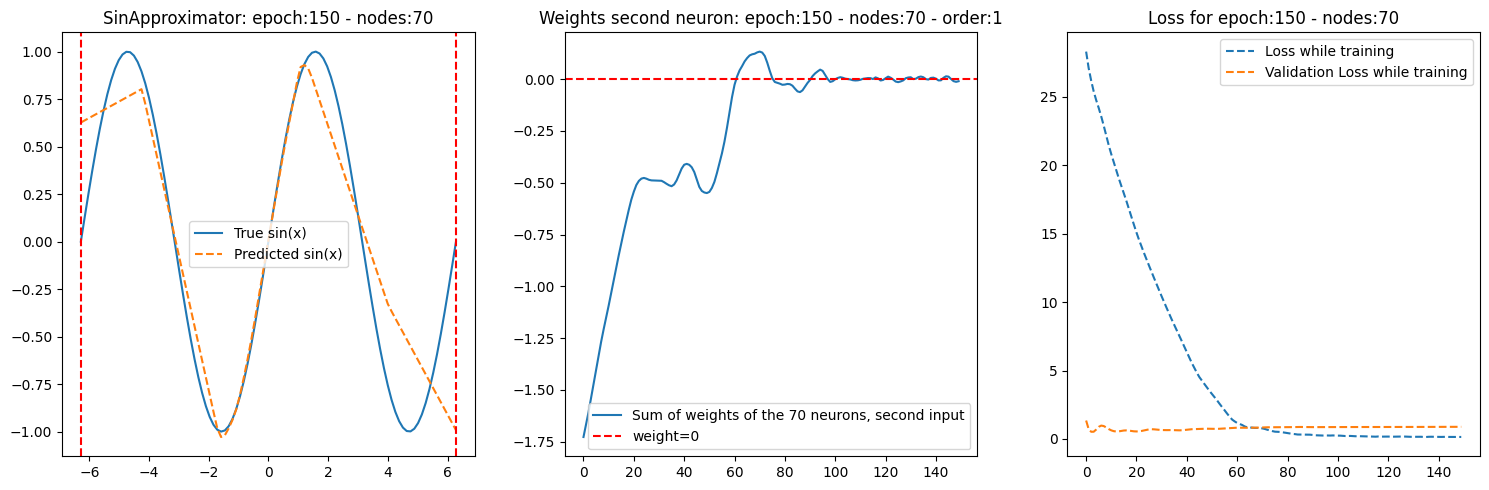

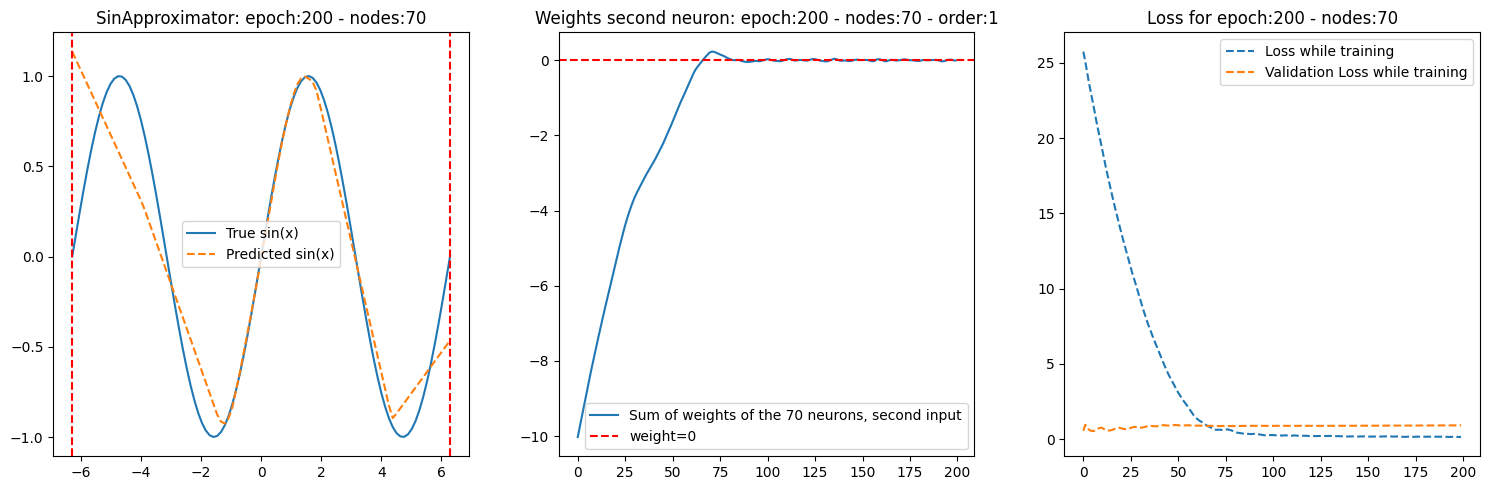

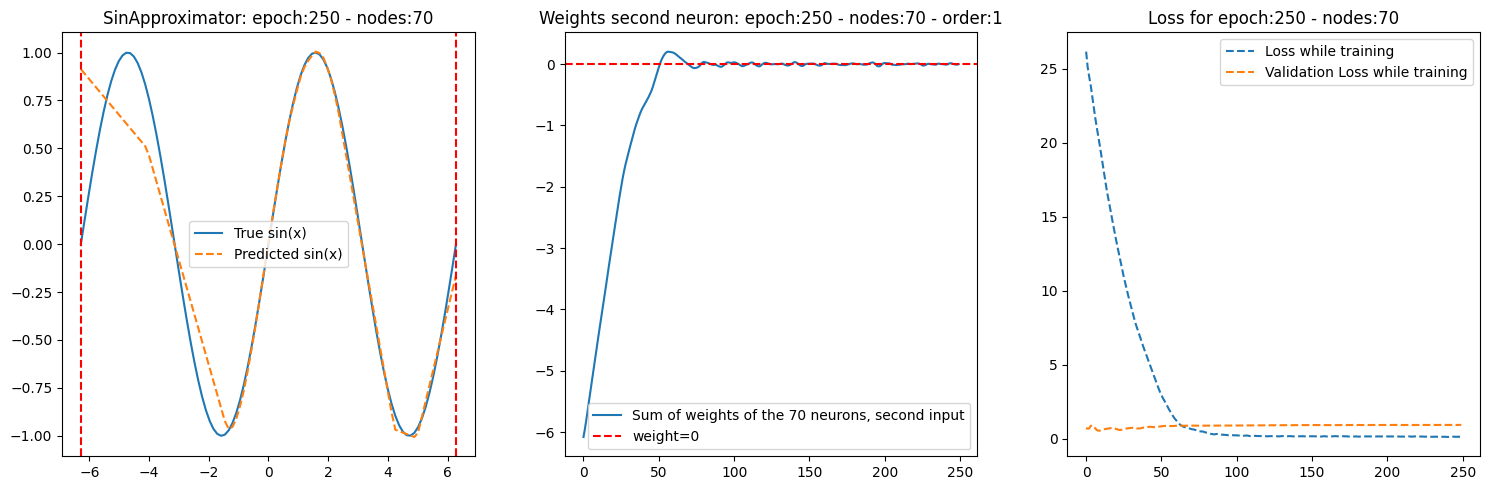

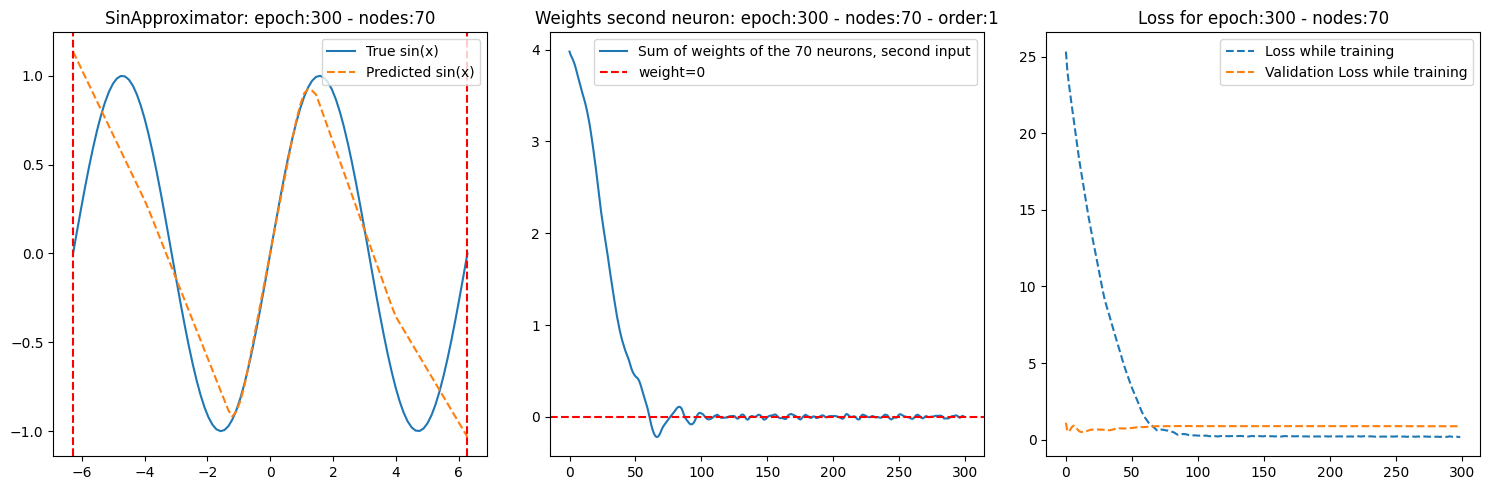

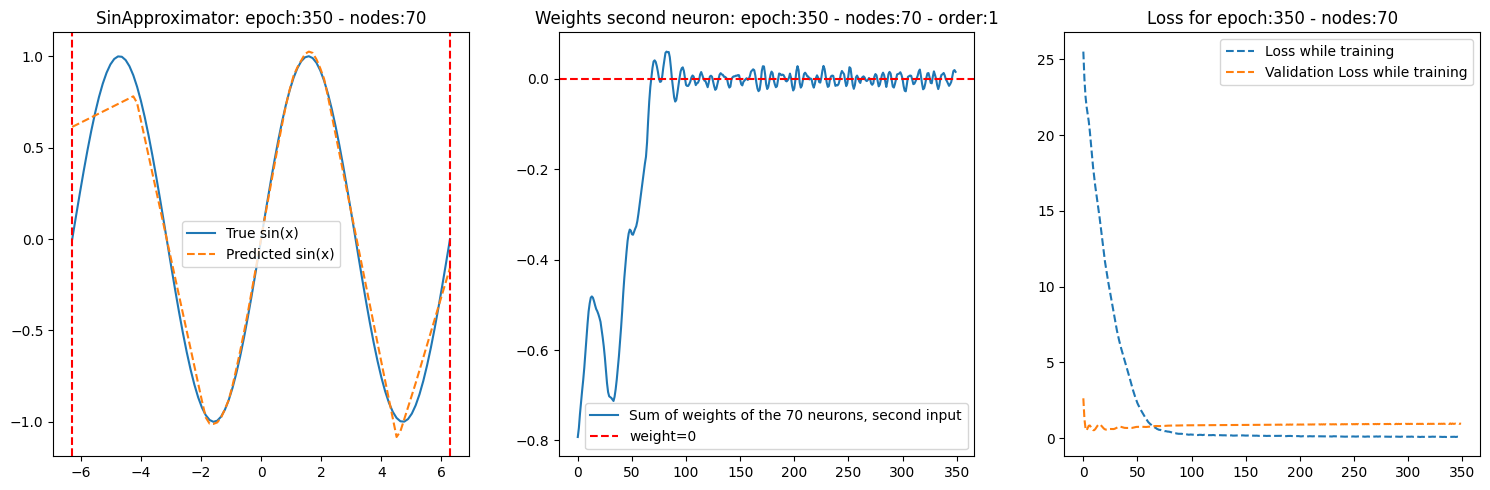

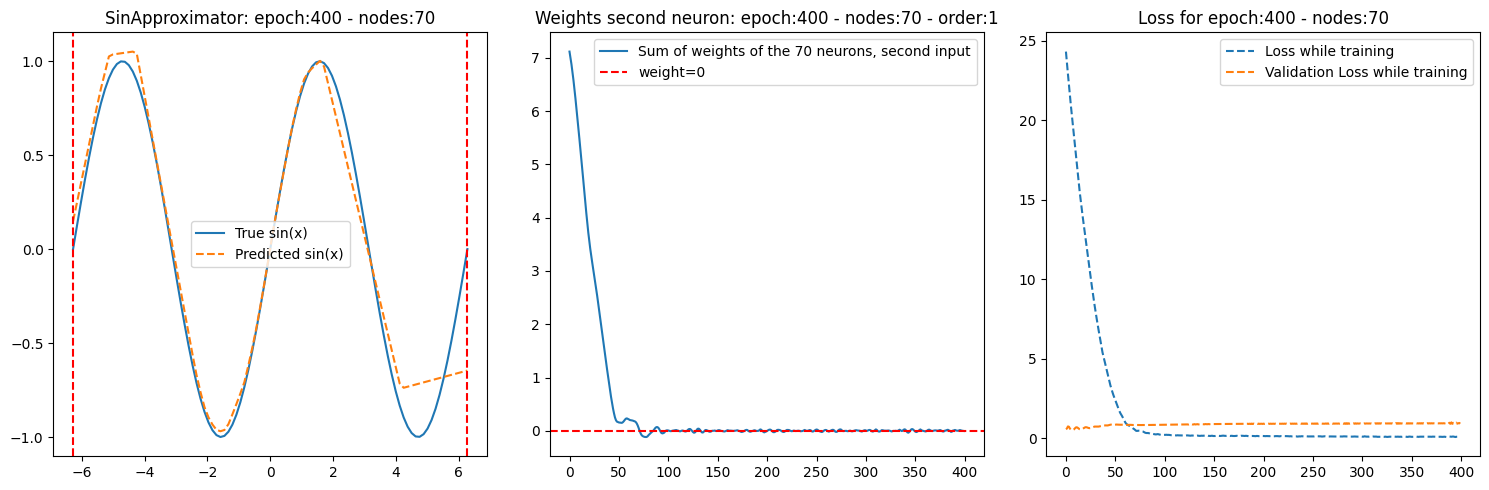

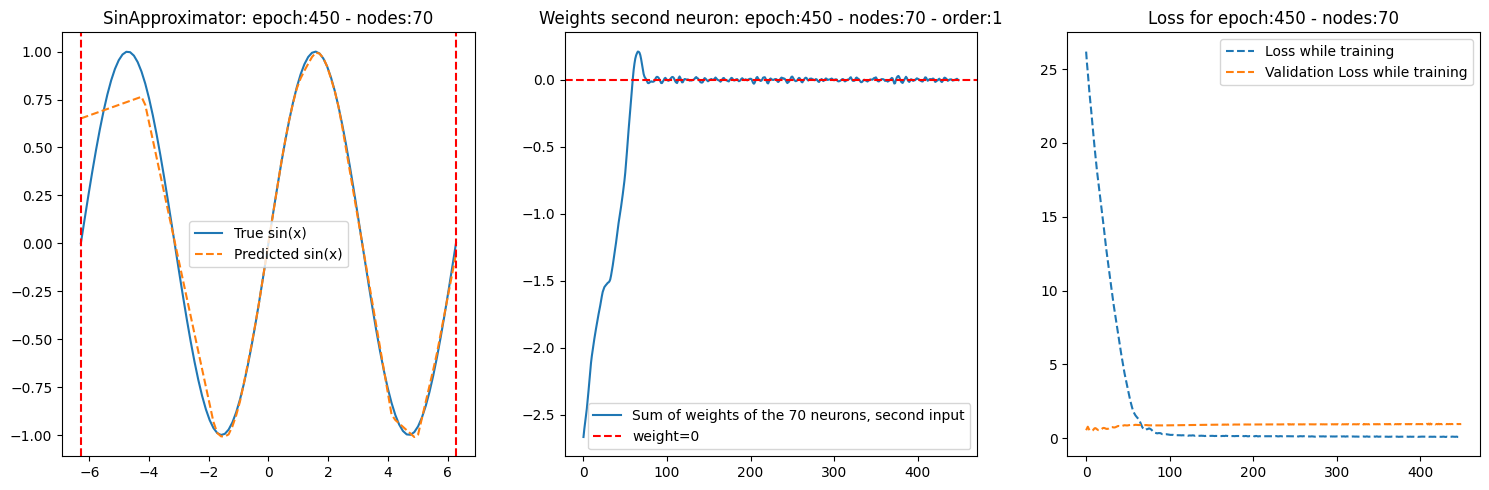

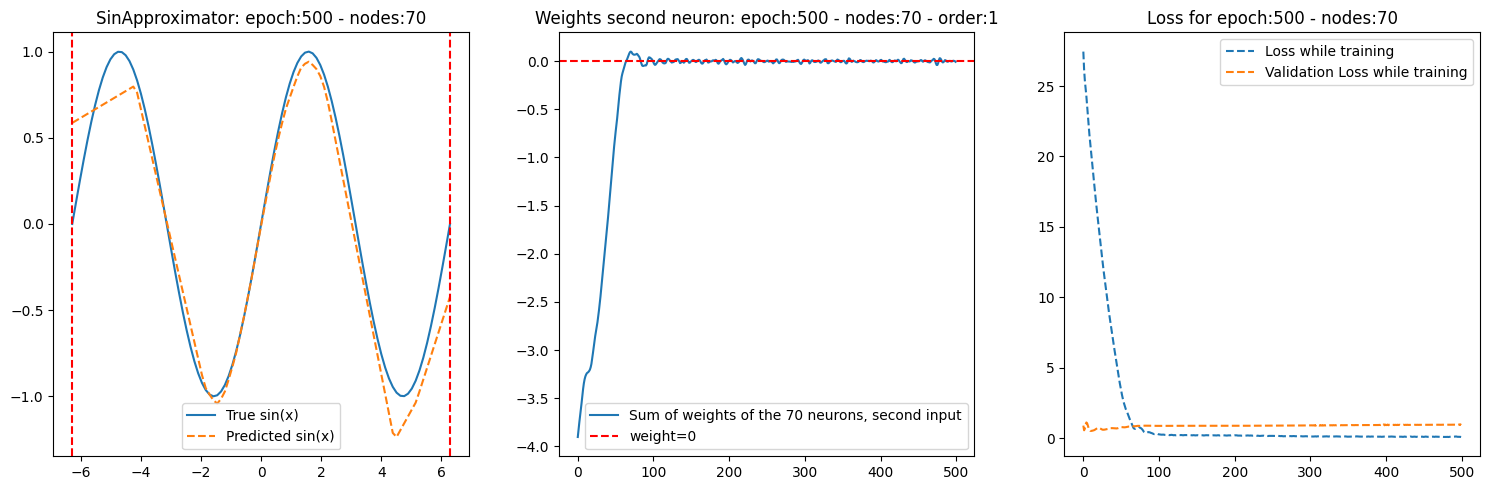

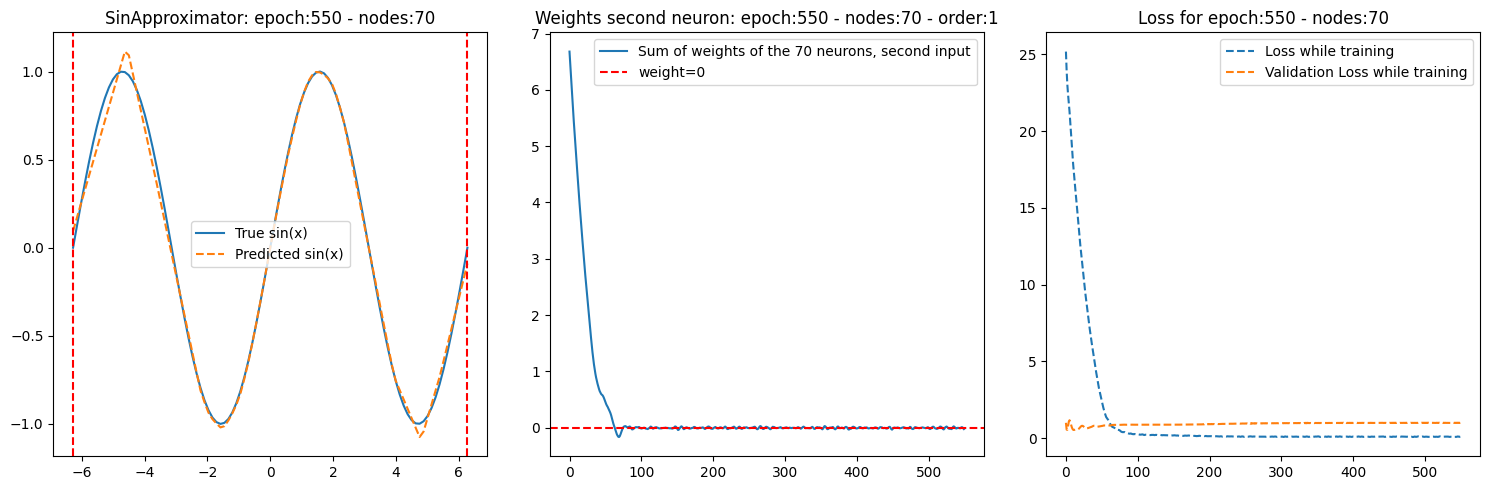

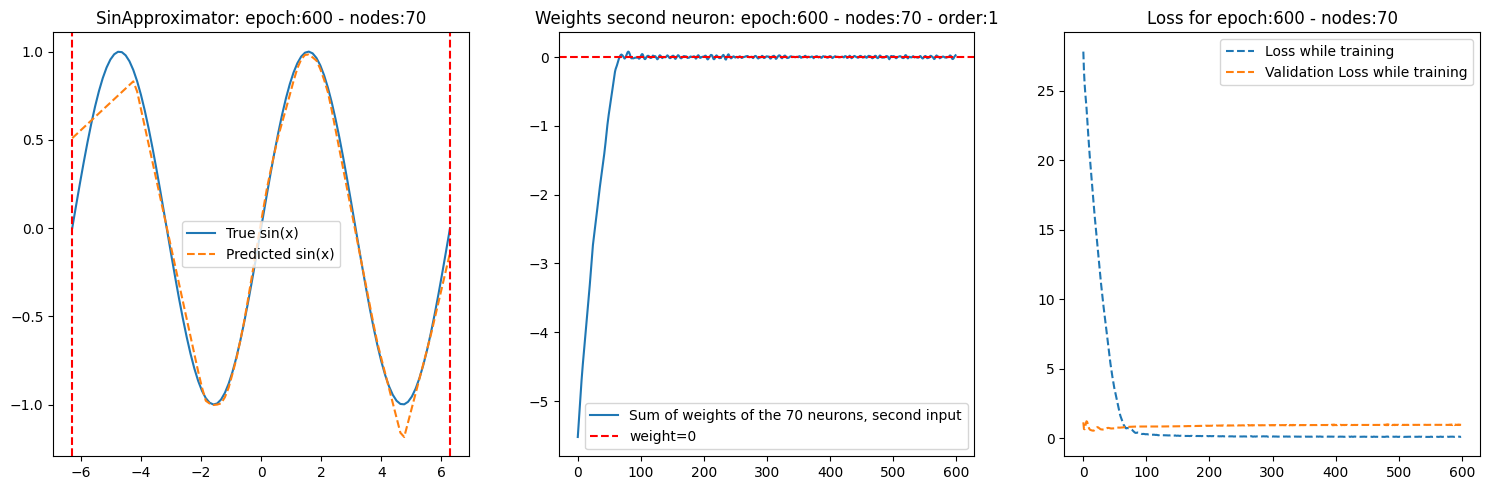

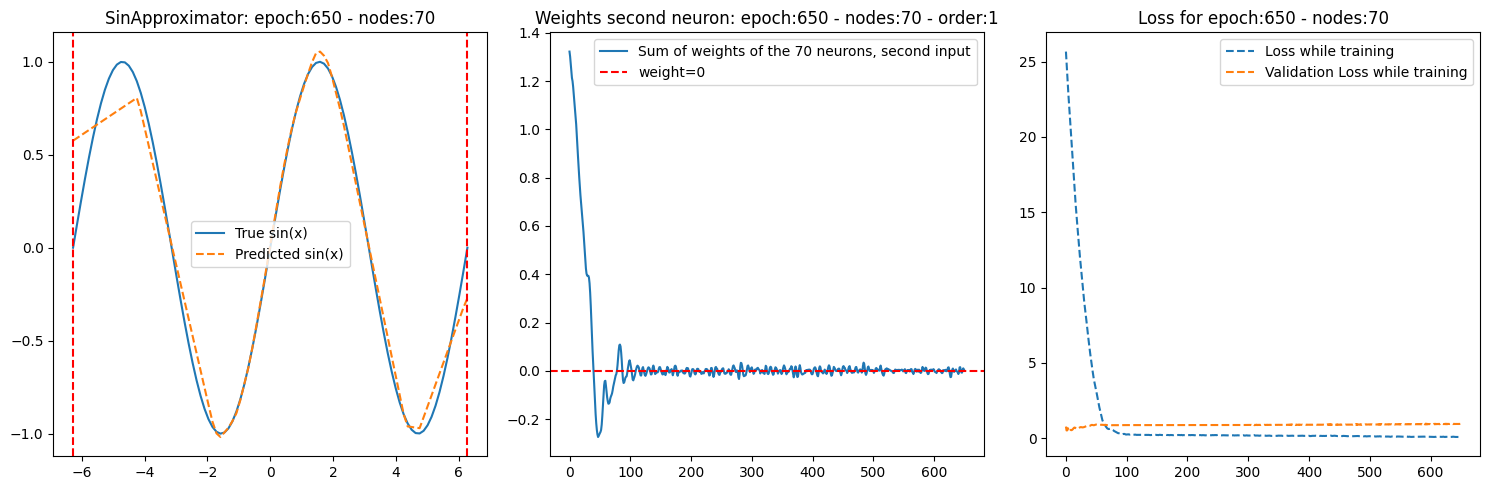

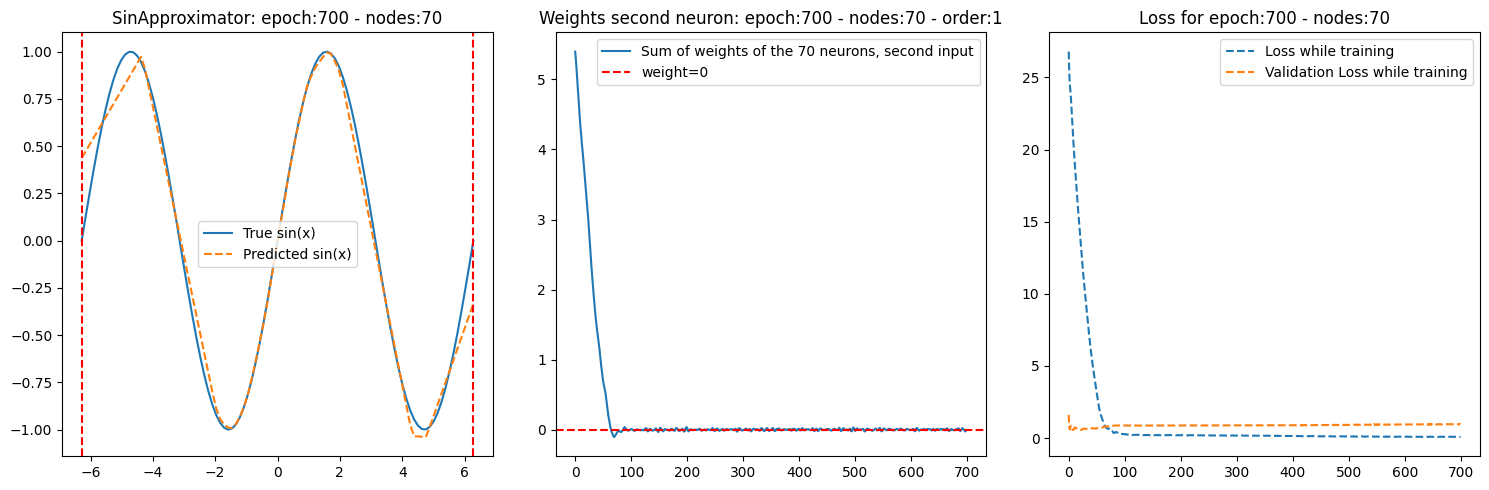

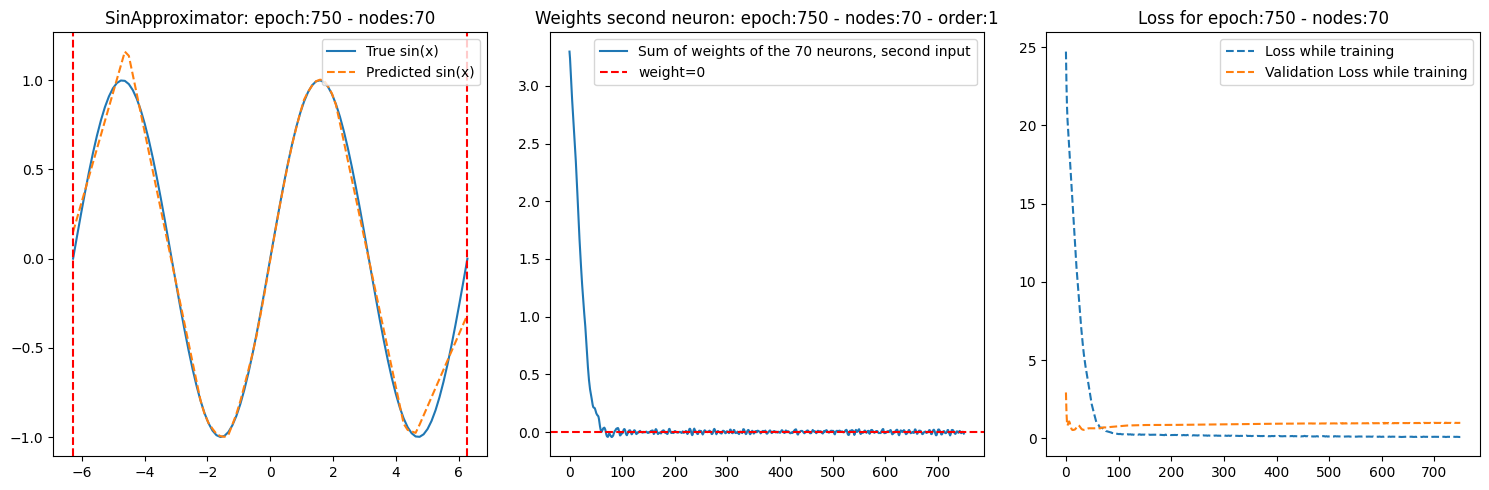

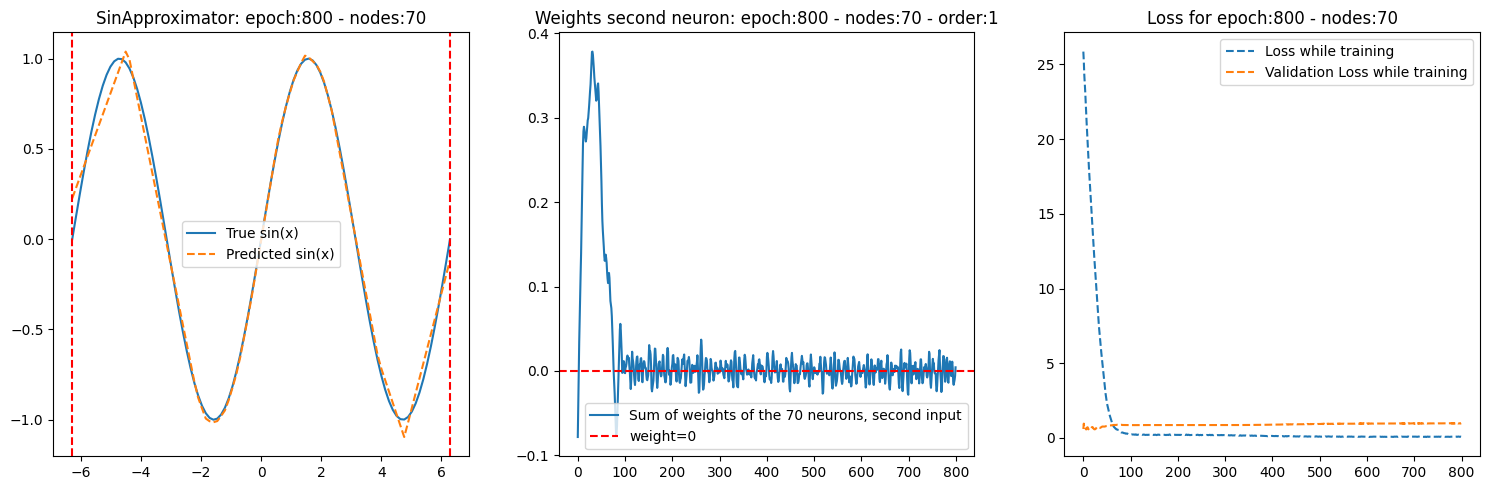

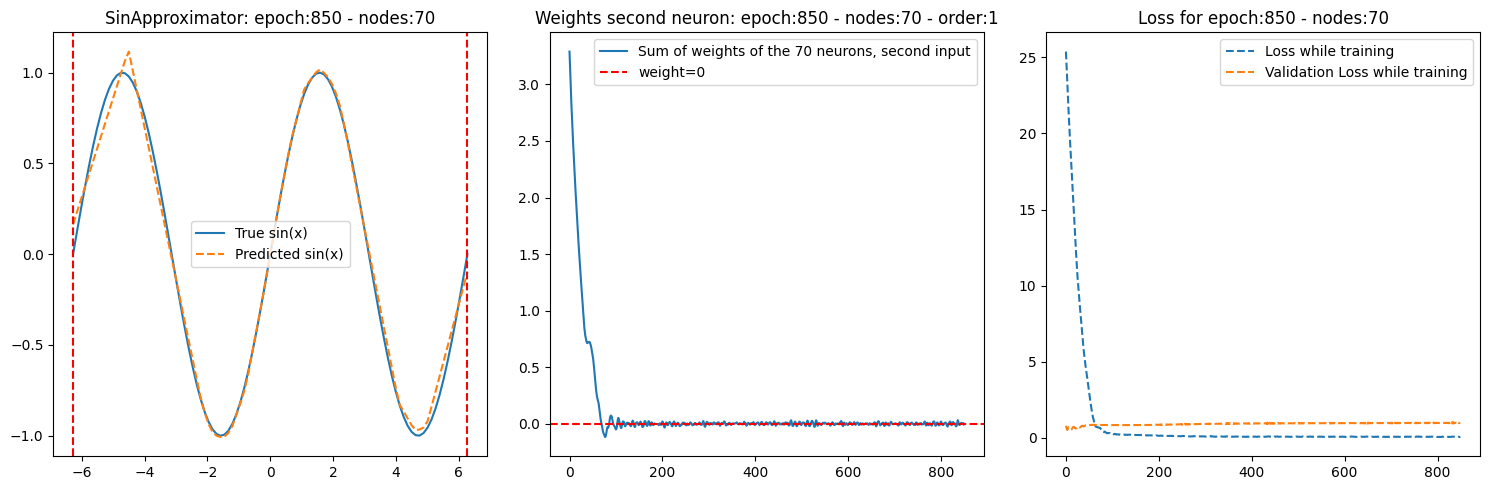

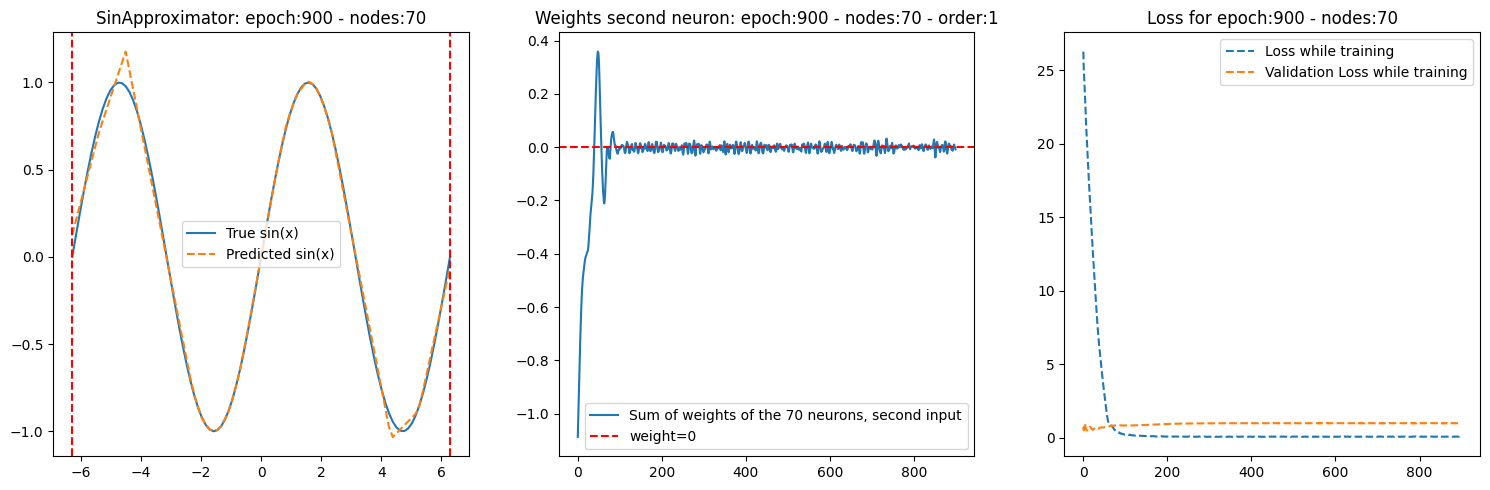

In [ ]:
# let's sample values to plot 
x_values = np.linspace(-interval *bit_much * np.pi, interval *bit_much * np.pi, 100)
x_values_ = np.vstack([x_values, np.zeros_like(x_values)])

for order in (1,2):
    for nodes in range(10, 100, 20):
        for epoch_number in range(50, 1000, 50):
                    
            model = SinApproximator(nodes=nodes)
            inputs, targets, validation, validation_y = generate_data(training_set_size, validation_set_size, how="random")

            # Train the model
            weights_b, losses, val_loss = train(model, inputs, targets, validation, validation_y, num_epochs=epoch_number, order=1)

            fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))


            with torch.no_grad():

                predictions = model(torch.tensor(x_values_.T, dtype=torch.float32)).numpy()

                # print(model.fc.weight[:, 1])
                # print(model.fc.weight[:, 0])

                axes[0].plot(x_values, np.sin(x_values), label="True sin(x)")
                axes[0].plot(x_values, predictions, label="Predicted sin(x)", linestyle="dashed")
                axes[0].set_title(f"SinApproximator: epoch:{epoch_number} - nodes:{nodes}")
                axes[0].axvline(x=-2*np.pi, color='red', linestyle='--')
                axes[0].axvline(x=2*np.pi, color='red', linestyle='--')

                axes[0].legend()

                axes[1].plot(weights_b, label=f"Sum of weights of the {nodes} neurons, second input")
                axes[1].set_title(f"Weights second neuron: epoch:{epoch_number} - nodes:{nodes} - order:{order}")
                axes[1].axhline(y=0, color='red', linestyle='--', label='weight=0')

                axes[1].legend()

                axes[2].plot(losses, label="Loss while training", linestyle="dashed")
                axes[2].plot(val_loss, label="Validation Loss while training", linestyle="dashed")
                axes[2].set_title(f"Loss for epoch:{epoch_number} - nodes:{nodes}")
                axes[2].legend()

                # Adjust layout for better spacing
                plt.tight_layout()

                plt.show()
